This script setup the experiments, assuming that the l4s part has been installed correctly. 

In [2]:
import subprocess

tx0_prefix = "ssh -p 25010 PeterYao@pc603.emulab.net"
router0_prefix = "ssh -p 25010 PeterYao@pc606.emulab.net"
router1_prefix = "ssh -p 25010 PeterYao@pc604.emulab.net"
rx0_prefix = "ssh PeterYao@pc615.emulab.net"

nodes_prefix = [tx0_prefix, router0_prefix, router1_prefix, rx0_prefix]

class node:
    def __init__(self, node_ssh_prefix) -> None:
        self.ssh_prefix = node_ssh_prefix

    def execute(self, command, background=False):
        if background:
            print("executing in background")
            # full_command = f"{self.ssh_prefix} 'setsid nohup {command} > /dev/null 2>&1 &'"
            full_command = f'{self.ssh_prefix} "{command}"'
            subprocess.Popen(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        else:
            full_command = f'{self.ssh_prefix} "{command}"'
            result = subprocess.run(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if result.returncode == 0:
                print(result.stdout.decode('utf-8'))
            else:
                print(f"Error: {result.stderr.decode('utf-8')}")
        return None
        
tx0_node = node(tx0_prefix)
delay_node = node(router0_prefix)
router_node = node(router1_prefix)
rx0_node = node(rx0_prefix)

nodes = [tx0_node, delay_node, router_node, rx0_node]





# Experiment 1 50-50 base thp and latency

In [3]:
commands_noecn = "bash -c 'sudo sysctl -w net.ipv4.tcp_congestion_control=cubic; sudo sysctl -w net.ipv4.tcp_ecn=0'"
for node in nodes:
    node.execute(commands_noecn)
    
print("validating...")
for node in nodes:
    node.execute("sudo sysctl net.ipv4.tcp_congestion_control")
    node.execute("sudo sysctl net.ipv4.tcp_ecn")

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0

validating...
net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0

net.ipv4.tcp_congestion_control = cubic

net.ipv4.tcp_ecn = 0



In [4]:
# modify the delay on the delay node
base_rtt = 25
delay_interfaces = ["eth1", "eth2"]

for e in delay_interfaces:
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=e, owd=base_rtt/2)
    delay_node.execute(cmds)

In [5]:
delay_node.execute("sudo tc qdisc show dev eth1")
delay_node.execute("sudo tc qdisc show dev eth2")

qdisc netem 8001: root refcnt 2 limit 60000 delay 12.5ms

qdisc netem 8002: root refcnt 2 limit 60000 delay 12.5ms



In [66]:
# set up the btl node
n_bdp = 2
base_rtt = 25
btl_capacity = 100 #in Mbps

# fixed values
btl_limit    = int(1000*n_bdp*btl_capacity*base_rtt/8) # limit of the bottleneck, n_bdp x BDP in bytes 
packet_number=int(btl_limit/1500)+1

print("btl limit: ", btl_limit)
print("packet number: ", packet_number)

btl limit:  625000
packet number:  417


In [1]:
from fabric import Connection

router = Connection(
    host='pc604.emulab.net',
    user='PeterYao',
    port=25010,
)


delay = Connection(
    host='pc606.emulab.net',
    user = 'PeterYao',
    port=25010,
)

tx = Connection(
    host='pc603.emulab.net',
    user = 'PeterYao',
    port=25010,
)

rx = Connection(
    host='pc615.emulab.net',
    user
    = 'PeterYao',  
    port=22,
)

result = router.run('df -h')

Filesystem      Size  Used Avail Use% Mounted on
tmpfs            96M  700K   96M   1% /run
/dev/xvda3       63G  3.8G   56G   7% /
tmpfs           480M     0  480M   0% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
/dev/xvda1      256M  8.6M  248M   4% /boot/efi
tmpfs            96M     0   96M   0% /run/user/39791


In [6]:
# setup the router queueing discipline
router_egress_name = "eth2"

cmds_prefix = '''
            sudo tc qdisc del dev {iface} root
            sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
            sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
            '''.format(iface=router_egress_name, capacity=btl_capacity, buffer=btl_limit)
            
cmds_specific = "sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer}".format(iface=router_egress_name, buffer=btl_limit)

router.run(cmds_prefix)    
router.run(cmds_specific)
router.run("sudo tc qdisc show dev eth2")  

router.run("sudo tc qdisc show dev eth2")



qdisc htb 1: root refcnt 2 r2q 10 default 0x3 direct_packets_stat 0 direct_qlen 1000
qdisc bfifo 3: parent 1:3 limit 625000b


<Result cmd='sudo tc qdisc show dev eth2' exited=0>

In [46]:
rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_congestion_control=cubic")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_congestion_control=cubic")

rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0")

net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_congestion_control = cubic
net.ipv4.tcp_ecn = 0
net.ipv4.tcp_ecn = 0


<Result cmd="sudo -S -p '[sudo] password: ' ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0" exited=0>

In [83]:
# run the iperf command
rx.run("killall iperf3", warn=True)

rx.sudo("ip netns exec ue1 iperf3 -s -1 -p 4000 -D")
rx.sudo("ip netns exec ue3 iperf3 -s -1 -p 4000 -D")

local_file_path = r"d:\5g notes\5G-E2E-Wireless-Notes-OAI\exp-9-15\exp.sh"

# the monitor queue length shell script has already been copied to the router1 node
router.run("nohup ./monitor.sh eth2 60 1 > monitor.log 2>&1 &", pty=False)

# the put command is funny on windows, so I copy paster the exp file manually to the tx node
tx.run("ls -l")
tx.run("chmod +x ~/exp.sh")
tx.run("~/exp.sh cubic-ecn-none")



iperf3: no process found


total 86552
-rw-r--r-- 1 PeterYao nyunetworks    34585 Sep 15 00:50 cubic_ecn_none-result-ue1.json
-rw-r--r-- 1 PeterYao nyunetworks    34634 Sep 15 00:50 cubic_ecn_none-result-ue2.json
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-1.csv
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-2.csv
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-processed-1.txt
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-processed-2.txt
-rw-r--r-- 1 PeterYao nyunetworks   220153 Sep 15 01:07 cubic_ecn_none-ss-processed-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks   234665 Sep 15 01:07 cubic_ecn_none-ss-processed-ue2.txt
-rw-r--r-- 1 PeterYao nyunetworks    10948 Sep 15 01:07 cubic_ecn_none-ss-ue1.csv
-rw-r--r-- 1 PeterYao nyunetworks   222167 Sep 15 00:50 cubic_ecn_none-ss-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks    10907 Sep 15 01:07 cubic_ecn_none-ss-ue2.csv
-rw-r--r-- 1 PeterYao nyunetworks   236460 S

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389557.434629 tcp SYN-SENT 0      1      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) timer:(on,792ms,0) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389557.435490 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:595700832 lastrcv:595700832 lastack:595700832 unacked:1 rcv_ssthresh:64240
1726389557.440562 tcp SYN-SENT 0      1      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) timer:(on,796ms,0) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389557.441236 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:595700824 lastrcv:595700824 lastack:595700824 unacked:1 rcv_ssthresh:64240


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389557.7558491726389557.756564 tcp ESTAB 0      125    10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) timer:(on,792ms,0) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      125    10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) timer:(on,648ms,0) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389557.7571481726389557.757372 	 ts sack cubic wscale:12,7 rto:924 rtt:298.118/143.821 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:41 bytes_acked:38 bytes_received:1 segs_out:5 segs_in:3 data_segs_out:2 data_segs_in:1 send 388571bps lastsnd:8 lastrcv:8 lastack:8 pacing_rate 777136bps delivery_rate 56856bps delivered:2 app_limited busy:212ms unacked:1 rcv_space:14480 rcv_ssthresh:64088 notsent:121 minrtt:203.723
 	 ts sack cubic wscale:12,7 rto:744 rtt:246.968/95.963 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:41 bytes_acked:38 bytes_received:1 segs_out:5 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389558.070511 tcp ESTAB 0      121    10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) timer:(on,568ms,0) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389558.071123 	 ts sack cubic wscale:12,7 rto:696 rtt:245.491/74.926 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:42 bytes_received:1 segs_out:6 segs_in:4 data_segs_out:3 data_segs_in:1 send 471871bps lastsnd:124 lastrcv:360 lastack:124 pacing_rate 943736bps delivery_rate 49256bps delivered:3 app_limited busy:596ms unacked:1 rcv_space:14480 rcv_ssthresh:64088 minrtt:235.154
1726389558.073956 tcp ESTAB 0      121    10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) timer:(on,732ms,0) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389558.074657 	 ts sack cubic wscale:12,7 rto:880 rtt:294.583/114.934 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:42 bytes_received:1 segs_out:6 segs_in:4 data_segs_out:3 data_segs_in:1 send 393234bps lastsnd:60 lastrcv:332 lastack:60 pacing_rate 786464bps delivery_rate 56856bps delivered:3 app_limited busy:536ms unacked:1 rcv_space:14480 rcv

Failed to open cgroup2 by ID


_ssthresh:64088 minrtt:203.723


Failed to open cgroup2 by ID


1726389558.497159 tcp ESTAB    0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389558.498553 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:2 segs_out:7 segs_in:6 data_segs_out:3 data_segs_in:2 send 409135bps lastsnd:372 lastrcv:172 lastack:172 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389558.499101 tcp SYN-SENT 0      1      10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,828ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389558.4996431726389558.501109 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:595701784 lastrcv:595701784 lastack:595701784 unacked:1 rcv_ssthresh:64240                        

Failed to open cgroup2 by ID


 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389558.511661 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:2 segs_out:7 segs_in:6 data_segs_out:3 data_segs_in:2 send 482098bps lastsnd:448 lastrcv:244 lastack:244 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389558.9006451726389558.901240 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389558.901878 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:3 segs_out:8 segs_in:7 data_segs_out:3 data_segs_in:3 send 409135bps lastsnd:816 lastrcv:72 lastack:72 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389558.902509 tcp ESTAB 0      0      10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389558.902841 	 ts sack cubic wscale:12,7 rto:908 rtt:295.976/131.542 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:38 segs_out:3 segs_in:2 data_segs_out:1 send 391383bps lastsnd:308 lastrcv:30

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389559.2171731726389559.225209 tcp ESTAB 0      153488 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,408ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389559.225630 	 ts sack cubic wscale:12,7 rto:664 rtt:238.769/6.112 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:20 bytes_sent:43477 bytes_acked:14518 segs_out:33 segs_in:12 data_segs_out:31 send 970310bps lastsnd:80 lastrcv:828 lastack:80 pacing_rate 1940616bps delivery_rate 481968bps delivered:12 app_limited busy:556ms unacked:20 rcv_space:14480 rcv_ssthresh:64088 notsent:124528 minrtt:235.558
1726389559.225718 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389559.225802 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389559.546871 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389559.547587 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:1528 lastrcv:548 lastack:548 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389559.548158 tcp ESTAB 0      150592 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,716ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389559.5487111726389559.549886 	 ts sack cubic wscale:12,7 rto:772 rtt:247.753/2.417 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:15 ssthresh:15 bytes_sent:65197 bytes_retrans:1448 bytes_acked:17414 segs_out:48 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389559.868765 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389559.8705521726389559.871472 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:1852 lastrcv:872 lastack:872 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389559.872095 tcp ESTAB 0      194032 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,364ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389559.872630 	 ts sack cubic wscale:12,7 rto:688 rtt:243.48/2.16 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:16 ssthresh:15 bytes_sent:88365 bytes_retrans:1448 bytes_acked:63750 segs_out:64 segs_in

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389560.1892831726389560.191593 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389560.192234 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:2172 lastrcv:1192 lastack:1192 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
 tcp ESTAB 0      405440 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,036ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389560.1930451726389560.193394 tcp ESTAB 0      188240 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,540ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389560.1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389560.5128841726389560.514321 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389560.514967 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:2496 lastrcv:1516 lastack:1516 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389560.515506 tcp ESTAB 0      181000 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,604ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389560.516064 	 ts sack cubic wscale:12,7 rto:620 rtt:237.814/4.606 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:11 bytes_sent:114429 bytes_retrans:18824 bytes_acked:76782 segs_out:82 se

Failed to open cgroup2 by ID


 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:2560 lastrcv:1616 lastack:1616 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                                  


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389560.844006 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389560.844675 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:2820 lastrcv:1840 lastack:1840 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389560.845217 tcp ESTAB 0      165072 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,488ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389560.845781 	 ts sack cubic wscale:12,7 rto:616 rtt:232.995/5.514 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:11 bytes_sent:123117 bytes_retrans:21720 bytes_acked:92710 segs_out:88 segs_in:55 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389561.1638591726389561.165910 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389561.166666 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:3152 lastrcv:2172 lastack:2172 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389561.167190 tcp ESTAB 0      159280 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,116ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389561.167747 	 ts sack cubic wscale:12,7 rto:576 rtt:238.28/8.595 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:11 bytes_sent:134701 bytes_retrans:21720 bytes_acked:98502 segs_out:96 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389561.4883601726389561.489314 tcp ESTAB 0      460464 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,244ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389561.489951 	 ts sack cubic wscale:12,7 rto:392 rtt:181.264/18.849 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:34 ssthresh:31 bytes_sent:732725 bytes_retrans:13032 bytes_acked:671910 segs_out:509 segs_in:362 data_segs_out:507 send 2172831bps lastsnd:8 lastrcv:3096 lastack:12 pacing_rate 2607384bps delivery_rate 2135912bps delivered:466 busy:2824ms unacked:33 retrans:0/9 rcv_space:14480 rcv_ssthresh:64088 notsent:412680 minrtt:104.11
1726389561.490629 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389561.491367 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389561.807938 tcp ESTAB 0      395304 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,156ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389561.810552 	 ts sack cubic wscale:12,7 rto:384 rtt:177.287/8.694 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:36 ssthresh:31 bytes_sent:800781 bytes_retrans:13032 bytes_acked:737070 segs_out:556 segs_in:385 data_segs_out:554 send 2352254bps lastsnd:56 lastrcv:3424 lastack:60 pacing_rate 2822688bps delivery_rate 1857904bps delivered:511 busy:3152ms unacked:35 retrans:0/9 rcv_space:14480 rcv_ssthresh:64088 notsent:344624 minrtt:104.11
1726389561.811165 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389561.811670 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389562.1298161726389562.133692 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389562.134406 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:4112 lastrcv:3132 lastack:3132 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389562.134998 tcp ESTAB 0      202720 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,296ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389562.135566 	 ts sack cubic wscale:12,7 rto:504 rtt:242.935/0.513 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:7 bytes_sent:183933 bytes_retrans:24616 bytes_acked:144838 segs_out:130 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389562.4521751726389562.455958 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389562.456633 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:4440 lastrcv:3460 lastack:3460 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389562.457251 tcp ESTAB 0      173760 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,428ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389562.457805 	 ts sack cubic wscale:12,7 rto:476 rtt:241.346/0.289 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:7 bytes_sent:212893 bytes_retrans:24616 bytes_acked:173798 segs_out:150 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389562.7748831726389562.775649 tcp ESTAB 0      448880 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,336ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389562.776305 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389562.776838 	 ts sack cubic wscale:12,7 rto:392 rtt:187.708/18.468 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:19 ssthresh:17 bytes_sent:990469 bytes_retrans:18824 bytes_acked:944134 segs_out:687 segs_in:454 data_segs_out:685 send 1172545bps lastsnd:24 lastrcv:4388 lastack:28 pacing_rate 1407040bps delivery_rate 965280bps delivered:654 busy:4116ms unacked:19 retrans:0/13 rcv_space:14480 rcv_ssthresh:64088 notsent:421368 minrtt:101.98
1726389562.777434 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389563.0970071726389563.098618 tcp ESTAB 0      445984 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,292ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389563.099279 	 ts sack cubic wscale:12,7 rto:428 rtt:224.876/21.416 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:13 bytes_sent:1009293 bytes_retrans:20272 bytes_acked:947030 segs_out:700 segs_in:464 data_segs_out:698 send 669667bps lastsnd:136 lastrcv:4708 lastack:140 pacing_rate 1298112bps delivery_rate 1005480bps delivered:672 busy:4436ms unacked:29 retrans:1/14 lost:1 sacked:16 rcv_space:14480 rcv_ssthresh:64088 notsent:403992 minrtt:101.98
1726389563.099809 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389563.100318 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachabl

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389563.4167981726389563.417626 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389563.418366 tcp ESTAB 0      386616 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,200ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389563.418932 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:5400 lastrcv:4420 lastack:4420 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389563.419492 	 ts sack cubic wscale:12,7 rto:420 rtt:217.015/11.727 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:16 ssthresh:13 bytes_sent:1048389 bytes_retrans:20272 bytes_acked:1006398 segs_out:7

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389563.735360 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389563.738560 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:5724 lastrcv:4744 lastack:4744 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389563.739147 tcp ESTAB 0      228784 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,316ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389563.739670 	 ts sack cubic wscale:12,7 rto:448 rtt:238/0.329 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:7 bytes_sent:291085 bytes_retrans:24616 bytes_acked:249094 segs_out:204 segs_in:163 data_segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389564.057359 tcp ESTAB 0      338832 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,260ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389564.062573 	 ts sack cubic wscale:12,7 rto:436 rtt:234.164/5.449 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:16 ssthresh:13 bytes_sent:1097621 bytes_retrans:20272 bytes_acked:1054182 segs_out:761 segs_in:493 data_segs_out:759 send 791514bps lastsnd:176 lastrcv:5668 lastack:176 pacing_rate 949808bps delivery_rate 777392bps delivered:730 busy:5396ms unacked:16 retrans:0/14 rcv_space:14480 rcv_ssthresh:64088 notsent:315664 minrtt:101.98
1726389564.063135 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389564.063701 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389564.3809561726389564.383384 tcp ESTAB 0      335936 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,420ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389564.384130 	 ts sack cubic wscale:12,7 rto:440 rtt:237.532/2.919 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:11 bytes_sent:1117893 bytes_retrans:26064 bytes_acked:1057078 segs_out:775 segs_in:501 data_segs_out:773 send 536450bps lastsnd:20 lastrcv:5988 lastack:20 pacing_rate 1228952bps delivery_rate 532304bps delivered:745 busy:5716ms unacked:24 retrans:4/18 lost:4 sacked:13 rcv_space:14480 rcv_ssthresh:64088 notsent:301184 minrtt:101.98
1726389564.384813 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389564.385366 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389564.704224 tcp ESTAB 0      505352 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,328ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389564.706648 	 ts sack cubic wscale:12,7 rto:440 rtt:236.069/4.404 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:7 bytes_sent:1130925 bytes_retrans:30408 bytes_acked:1083142 segs_out:784 segs_in:509 data_segs_out:782 send 343493bps lastsnd:112 lastrcv:6320 lastack:112 pacing_rate 471072bps delivery_rate 340840bps delivered:755 busy:6048ms unacked:12 retrans:3/21 lost:3 sacked:5 rcv_space:14480 rcv_ssthresh:64088 notsent:487976 minrtt:101.98
1726389564.707194 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389564.707738 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389565.0251691726389565.027167 tcp ESTAB 0      487976 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,248ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389565.027809 	 ts sack cubic wscale:12,7 rto:440 rtt:236.363/1.326 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:7 bytes_sent:1141061 bytes_retrans:30408 bytes_acked:1100518 segs_out:791 segs_in:514 data_segs_out:789 send 343066bps lastsnd:192 lastrcv:6640 lastack:196 pacing_rate 411672bps delivery_rate 342496bps delivered:762 busy:6368ms unacked:7 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:477840 minrtt:101.98
1726389565.028385 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389565.02917817

Failed to open cgroup2 by ID


 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:7080 lastrcv:6136 lastack:6136 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                  
 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:7008 lastrcv:6028 lastack:6028 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389565.031861 tcp ESTAB 0      137560 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,432ms,0) uid:39791 ino:200946 sk:70 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


cgroup:unreachable:2010c00000052 <->
1726389565.032402 	 ts sack cubic wscale:12,7 rto:444 rtt:241.72/8.162 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:14 ssthresh:7 bytes_sent:386653 bytes_retrans:24616 bytes_acked:340318 segs_out:270 segs_in:226 data_segs_out:268 send 670925bps lastsnd:12 lastrcv:6500 lastack:192 pacing_rate 805104bps delivery_rate 556656bps delivered:237 busy:6260ms unacked:15 retrans:0/17 rcv_space:14480 rcv_ssthresh:64088 notsent:115840 minrtt:209


Failed to open cgroup2 by ID


1726389565.3445551726389565.345666 tcp ESTAB 0      466256 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,312ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389565.346392 	 ts sack cubic wscale:12,7 rto:416 rtt:215.166/5.699 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:7 bytes_sent:1165677 bytes_retrans:30408 bytes_acked:1122238 segs_out:808 segs_in:522 data_segs_out:806 send 484538bps lastsnd:104 lastrcv:6960 lastack:104 pacing_rate 581440bps delivery_rate 450672bps delivered:777 busy:6688ms unacked:9 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:453224 minrtt:101.98
1726389565.346907 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389565.347459 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
17

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389565.6613021726389565.664622 tcp ESTAB 0      453224 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,196ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389565.665295 	 ts sack cubic wscale:12,7 rto:412 rtt:209.982/6.072 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:7 bytes_sent:1178709 bytes_retrans:30408 bytes_acked:1135270 segs_out:817 segs_in:527 data_segs_out:815 send 496500bps lastsnd:216 lastrcv:7276 lastack:216 pacing_rate 595792bps delivery_rate 508688bps delivered:786 busy:7004ms unacked:9 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:440192 minrtt:101.98
1726389565.665834 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389565.666474 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389565.9816751726389565.983586 tcp ESTAB 0      427160 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,372ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389565.984196 	 ts sack cubic wscale:12,7 rto:432 rtt:229.802/10.589 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:7 bytes_sent:1204773 bytes_retrans:30408 bytes_acked:1161334 segs_out:835 segs_in:537 data_segs_out:833 send 453678bps lastsnd:60 lastrcv:7596 lastack:60 pacing_rate 544408bps delivery_rate 435960bps delivered:804 busy:7324ms unacked:9 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:414128 minrtt:101.98
1726389565.984707 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->


Failed to open cgroup2 by ID


1726389565.985229 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:8036 lastrcv:7092 lastack:7092 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                 
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389565.987546 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:7964 lastrcv:6984 lastack:6984 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389566.3013321726389566.303253 tcp ESTAB 0      414128 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,296ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389566.303919 	 ts sack cubic wscale:12,7 rto:436 rtt:234.387/7.6 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:7 bytes_sent:1220701 bytes_retrans:30408 bytes_acked:1174366 segs_out:846 segs_in:542 data_segs_out:844 send 543648bps lastsnd:140 lastrcv:7916 lastack:140 pacing_rate 652368bps delivery_rate 435008bps delivered:813 busy:7644ms unacked:11 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:398200 minrtt:101.98
1726389566.304435 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389566.304840 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389566.6213901726389566.623446 tcp ESTAB 0      382272 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,412ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389566.624097 	 ts sack cubic wscale:12,7 rto:432 rtt:227.986/11.625 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:7 bytes_sent:1252557 bytes_retrans:30408 bytes_acked:1206222 segs_out:868 segs_in:554 data_segs_out:866 send 558912bps lastsnd:20 lastrcv:8236 lastack:20 pacing_rate 670688bps delivery_rate 538232bps delivered:835 busy:7964ms unacked:11 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:366344 minrtt:101.98
1726389566.624609 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389566.625149 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receive

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389566.939895 tcp ESTAB 0      366344 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,340ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389566.942537 	 ts sack cubic wscale:12,7 rto:436 rtt:233.9/7.758 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:7 bytes_sent:1268485 bytes_retrans:30408 bytes_acked:1222150 segs_out:879 segs_in:560 data_segs_out:877 send 544780bps lastsnd:96 lastrcv:8552 lastack:96 pacing_rate 653728bps delivery_rate 532880bps delivered:846 busy:8280ms unacked:11 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:350416 minrtt:101.98
1726389566.943079 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389566.943630 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389567.2571561726389567.260526 tcp ESTAB 0      350416 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,260ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389567.261177 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 	 ts sack cubic wscale:12,7 rto:436 rtt:235.569/2.777 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:7 bytes_sent:1287309 bytes_retrans:30408 bytes_acked:1238078 segs_out:892 segs_in:566 data_segs_out:890 send 639269bps lastsnd:176 lastrcv:8872 lastack:180 pacing_rate 767120bps delivery_rate 531024bps delivered:857 busy:8600ms unacked:13 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:331592 minrtt:101.98
1726389567.2620181726389567.262388 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389567.579830 tcp ESTAB 0      508248 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,420ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389567.580622 	 ts sack cubic wscale:12,7 rto:440 rtt:236.502/0.624 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:7 bytes_sent:1324957 bytes_retrans:30408 bytes_acked:1275726 segs_out:918 segs_in:580 data_segs_out:916 send 636747bps lastsnd:20 lastrcv:9192 lastack:24 pacing_rate 764088bps delivery_rate 631080bps delivered:883 busy:8920ms unacked:13 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:489424 minrtt:101.98
1726389567.581112 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389567.581643 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389567.900221 tcp ESTAB 0      489424 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,336ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389567.900881 	 ts sack cubic wscale:12,7 rto:440 rtt:236.752/0.464 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:7 bytes_sent:1343781 bytes_retrans:30408 bytes_acked:1294550 segs_out:931 segs_in:587 data_segs_out:929 send 636075bps lastsnd:104 lastrcv:9512 lastack:104 pacing_rate 763288bps delivery_rate 633480bps delivered:896 busy:9240ms unacked:13 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:470600 minrtt:101.98
1726389567.901446 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389567.901977 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389568.2176491726389568.220269 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      470600 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,256ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389568.2211801726389568.221508 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:10200 lastrcv:9220 lastack:9220 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389568.222014 	 ts sack cubic wscale:12,7 rto:440 rtt:237.71/0.728 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:15 ssthresh:7 bytes_sent:1365501 bytes_retrans:30408 bytes_acked:1313374 segs_out:946

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


 tcp ESTAB 0      137560 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,316ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389568.223246 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389568.223719 	 ts sack cubic wscale:12,7 rto:432 rtt:230.398/6.263 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:5 bytes_sent:522765 bytes_retrans:40544 bytes_acked:470638 segs_out:364 segs_in:288 data_segs_out:362 send 251391bps lastsnd:116 lastrcv:9692 lastack:116 pacing_rate 362000bps delivery_rate 145296bps delivered:330 busy:9452ms unacked:8 retrans:3/28 lost:3 sacked:3 rcv_space:14480 rcv_ssthresh:64088 notsent:125976 minrtt:202.741
 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389568.855374 tcp ESTAB 0      405440 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,272ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389568.858560 	 ts sack cubic wscale:12,7 rto:416 rtt:214.992/5.059 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:15 ssthresh:7 bytes_sent:1430661 bytes_retrans:30408 bytes_acked:1378534 segs_out:991 segs_in:618 data_segs_out:989 send 808216bps lastsnd:144 lastrcv:10472 lastack:148 pacing_rate 969856bps delivery_rate 733152bps delivered:954 busy:10200ms unacked:15 retrans:0/21 rcv_space:14480 rcv_ssthresh:64088 notsent:383720 minrtt:101.98
1726389568.859154 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389568.859614 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:10912 lastrcv:9968 lastack:9968 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                     
1726389568.863014 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389568.863703 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:10840 lastrcv:9860 lastack:9860 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389569.4962771726389569.498786 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389569.499162 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:11480 lastrcv:10500 lastack:10500 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389569.499274 tcp ESTAB 0      160728 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,196ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389569.499329 	 ts sack cubic wscale:12,7 rto:436 rtt:232.263/8.516 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:5 bytes_sent:561861 bytes_retrans:40544 bytes_acked:512630 segs_out:39

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389569.8215941726389569.824819 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389569.825481 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:11804 lastrcv:10824 lastack:10824 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
 tcp ESTAB 0      516936 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,228ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389569.8263441726389569.826693 tcp ESTAB 0      149144 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,308ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
172638956

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389570.1405601726389570.141922 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389570.142658 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:12128 lastrcv:11148 lastack:11148 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389570.143194 tcp ESTAB 0      133216 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,424ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389570.143743 tcp ESTAB 0      495216 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,160ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
172638957

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389570.460265 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389570.460924 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:12448 lastrcv:11468 lastack:11468 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389570.461443 tcp ESTAB 0      123080 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,344ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389570.462551 	 ts sack cubic wscale:12,7 rto:432 rtt:230.69/9.869 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:603853 bytes_retrans:43440 bytes_acked:550278 segs_out:420 segs_in:318 data

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389570.7767521726389570.779673 tcp ESTAB 0      487976 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,320ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389570.780293 	 ts sack cubic wscale:12,7 rto:420 rtt:218.891/26.428 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:10 bytes_sent:1560981 bytes_retrans:47784 bytes_acked:1491478 segs_out:1081 segs_in:664 data_segs_out:1079 send 529213bps lastsnd:100 lastrcv:12392 lastack:100 pacing_rate 825568bps delivery_rate 244120bps delivered:1037 busy:12120ms unacked:15 retrans:6/33 lost:6 sacked:5 rcv_space:14480 rcv_ssthresh:64088 notsent:466256 minrtt:101.98
1726389570.780896 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389570.781457 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389571.0972931726389571.099050 tcp ESTAB 0      451776 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,344ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389571.099668 	 ts sack cubic wscale:12,7 rto:420 rtt:219.131/17.635 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:10 bytes_sent:1591389 bytes_retrans:47784 bytes_acked:1527678 segs_out:1102 segs_in:677 data_segs_out:1100 send 581497bps lastsnd:44 lastrcv:12712 lastack:44 pacing_rate 697792bps delivery_rate 564536bps delivered:1057 busy:12440ms unacked:11 retrans:0/33 rcv_space:14480 rcv_ssthresh:64088 notsent:435848 minrtt:101.98
1726389571.100258 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389571.100766 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389571.4153311726389571.417204 tcp ESTAB 0      435848 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,212ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389571.417856 	 ts sack cubic wscale:12,7 rto:404 rtt:202.839/15.667 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:10 bytes_sent:1608765 bytes_retrans:47784 bytes_acked:1543606 segs_out:1114 segs_in:683 data_segs_out:1112 send 685312bps lastsnd:192 lastrcv:13032 lastack:192 pacing_rate 822368bps delivery_rate 744360bps delivered:1068 busy:12760ms unacked:12 retrans:0/33 rcv_space:14480 rcv_ssthresh:64088 notsent:418472 minrtt:101.98
1726389571.418509 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389571.418883 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389571.737085 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389571.737752 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:13716 lastrcv:12736 lastack:12736 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389571.738539 tcp ESTAB 0      212856 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,208ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389571.7390641726389571.740004 	 ts sack cubic wscale:12,7 rto:476 rtt:273.738/38.309 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:644397 bytes_retrans:43440 bytes_acked:590822 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389572.054788 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389572.0554211726389572.056038 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:14044 lastrcv:13064 lastack:13064 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389572.056712 tcp ESTAB 0      192584 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,420ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389572.057206 	 ts sack cubic wscale:12,7 rto:472 rtt:268.932/32.584 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:4 bytes_sent:667565 bytes_retrans:43440 bytes_acked:611094 segs_out:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389572.371757 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389572.374579 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:14360 lastrcv:13380 lastack:13380 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389572.375181 tcp ESTAB 0      179552 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,332ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389572.375674 	 ts sack cubic wscale:12,7 rto:460 rtt:256.389/26.774 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:4 bytes_sent:680597 bytes_retrans:43440 bytes_acked:624126 segs_out:473 segs_in:341 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389572.694696 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389572.695374 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:14680 lastrcv:13700 lastack:13700 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389572.695896 tcp ESTAB 0      166520 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,332ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389572.696432 	 ts sack cubic wscale:12,7 rto:476 rtt:272.431/35.372 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:4 bytes_sent:693629 bytes_retrans:43440 bytes_acked:637158 segs_out:482 segs_in:344 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389573.0131191726389573.016661 tcp ESTAB 0      335936 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,232ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389573.017290 	 ts sack cubic wscale:12,7 rto:420 rtt:217.6/22.587 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:8 bytes_sent:1711573 bytes_retrans:53576 bytes_acked:1643518 segs_out:1185 segs_in:722 data_segs_out:1183 send 532353bps lastsnd:88 lastrcv:14624 lastack:88 pacing_rate 638816bps delivery_rate 340480bps delivered:1137 busy:14352ms unacked:10 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:321456 minrtt:73.482
1726389573.017851 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389573.018524 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <-

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389573.3337071726389573.336001 tcp ESTAB 0      502456 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,312ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389573.336606 	 ts sack cubic wscale:12,7 rto:416 rtt:213.348/18.674 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:8 bytes_sent:1741981 bytes_retrans:53576 bytes_acked:1672478 segs_out:1206 segs_in:733 data_segs_out:1204 send 597259bps lastsnd:104 lastrcv:14948 lastack:104 pacing_rate 716704bps delivery_rate 623720bps delivered:1157 busy:14676ms unacked:11 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:486528 minrtt:73.482
1726389573.337153 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389573.

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389573.6530031726389573.654535 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389573.655162 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:15640 lastrcv:14660 lastack:14660 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
 tcp ESTAB 0      486528 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,256ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389573.6560671726389573.656372 tcp ESTAB 0      139008 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,232ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
 	 ts sac

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389573.9714561726389573.972307 tcp ESTAB 0      448880 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,356ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389573.972911 	 ts sack cubic wscale:12,7 rto:416 rtt:214.564/10.184 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:8 bytes_sent:1798453 bytes_retrans:53576 bytes_acked:1726054 segs_out:1245 segs_in:753 data_segs_out:1243 send 701851bps lastsnd:60 lastrcv:15584 lastack:64 pacing_rate 842216bps delivery_rate 632032bps delivered:1194 busy:15312ms unacked:13 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:430056 minrtt:73.482
1726389573.973463 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389573.973999 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389574.2884621726389574.291915 tcp ESTAB 0      430056 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,232ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389574.292544 	 ts sack cubic wscale:12,7 rto:408 rtt:207.125/7.946 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:8 bytes_sent:1817277 bytes_retrans:53576 bytes_acked:1744878 segs_out:1258 segs_in:760 data_segs_out:1256 send 727059bps lastsnd:176 lastrcv:15904 lastack:180 pacing_rate 872464bps delivery_rate 740320bps delivered:1207 busy:15632ms unacked:13 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:411232 minrtt:73.482
1726389574.293099 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389574.293628 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389574.6087411726389574.612463 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389574.613093 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:16592 lastrcv:15612 lastack:15612 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389574.613664 tcp ESTAB 0      121632 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,416ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389574.614148 	 ts sack cubic wscale:12,7 rto:468 rtt:250.388/41.401 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:5 bytes_sent:751549 bytes_retrans:57920 bytes_acked:682046 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389574.9287561726389574.931877 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389574.932536 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:16916 lastrcv:15936 lastack:15936 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389574.933049 tcp ESTAB 0      240368 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,228ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389574.933587 	 ts sack cubic wscale:12,7 rto:432 rtt:217.168/44.344 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:5 bytes_sent:758789 bytes_retrans:57920 bytes_acked:693630 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389575.248469 tcp ESTAB 0      335936 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,404ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389575.250575 	 ts sack cubic wscale:12,7 rto:416 rtt:214.91/8.434 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:8 bytes_sent:1911397 bytes_retrans:53576 bytes_acked:1838998 segs_out:1323 segs_in:795 data_segs_out:1321 send 700721bps lastsnd:12 lastrcv:16860 lastack:12 pacing_rate 840856bps delivery_rate 636960bps delivered:1272 busy:16588ms unacked:13 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:317112 minrtt:73.482
1726389575.251148 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389575.251639 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


 	 ts sack cubic wscale:12,7 rto:496 rtt:245.9/61.865 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:5 bytes_sent:767477 bytes_retrans:57920 bytes_acked:700870 segs_out:533 segs_in:375 data_segs_out:531 send 282651bps lastsnd:220 lastrcv:16728 lastack:220 pacing_rate 339176bps delivery_rate 190280bps delivered:486 busy:16488ms unacked:6 retrans:0/40 rcv_space:14480 rcv_ssthresh:64088 notsent:224440 minrtt:169.604


Failed to open cgroup2 by ID


1726389575.5673971726389575.569458 tcp ESTAB 0      512592 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,332ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389575.570092 	 ts sack cubic wscale:12,7 rto:428 rtt:226.688/12.86 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:15 ssthresh:8 bytes_sent:1933117 bytes_retrans:53576 bytes_acked:1857822 segs_out:1338 segs_in:801 data_segs_out:1336 send 766516bps lastsnd:96 lastrcv:17184 lastack:100 pacing_rate 919816bps delivery_rate 635240bps delivered:1285 busy:16912ms unacked:15 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:490872 minrtt:73.482
1726389575.570744 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389575.571074 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389575.8849981726389575.886979 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389575.887639 tcp ESTAB 0      490872 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,260ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389575.888151 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:17868 lastrcv:16888 lastack:16888 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
 	 ts sack cubic wscale:12,7 rto:436 rtt:232.572/5.23 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:15 ssthresh:8 bytes_sent:1954837 bytes_retrans:53576 bytes_acked:1879542 segs_out:1353 segs_in:809 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389576.2039431726389576.204989 tcp ESTAB 0      450328 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,188ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389576.205598 	 ts sack cubic wscale:12,7 rto:440 rtt:236.981/0.965 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:15 ssthresh:8 bytes_sent:1993933 bytes_retrans:53576 bytes_acked:1920086 segs_out:1380 segs_in:824 data_segs_out:1378 send 733223bps lastsnd:16 lastrcv:17816 lastack:16 pacing_rate 879864bps delivery_rate 632192bps delivered:1328 busy:17544ms unacked:14 retrans:0/37 rcv_space:14480 rcv_ssthresh:64088 notsent:430056 minrtt:73.482
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389576.2065431726389576.206153 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389576.5210201726389576.523507 tcp ESTAB 0      450328 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,340ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389576.524132 	 ts sack cubic wscale:12,7 rto:440 rtt:237.395/0.646 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:10 bytes_sent:2008413 bytes_retrans:56472 bytes_acked:1920086 segs_out:1390 segs_in:829 data_segs_out:1388 send 487963bps lastsnd:100 lastrcv:18136 lastack:100 pacing_rate 878328bps delivery_rate 583544bps delivered:1340 busy:17864ms unacked:22 retrans:2/39 lost:2 sacked:12 rcv_space:14480 rcv_ssthresh:64088 notsent:418472 minrtt:73.482
1726389576.524713 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389576.525269 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreach

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389576.8411251726389576.843066 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389576.843688 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:18824 lastrcv:17844 lastack:17844 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389576.844293 tcp ESTAB 0      418472 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,204ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389576.844851 tcp ESTAB 0      181000 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,412ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
172638957

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389577.1592361726389577.161878 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389577.162621 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:19144 lastrcv:18164 lastack:18164 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389577.163198 tcp ESTAB 0      170864 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,332ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389577.163684 	 ts sack cubic wscale:12,7 rto:452 rtt:237.967/2.359 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:834085 bytes_retrans:60816 bytes_acked:763134 segs_out:57

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389577.479608 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389577.482572 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:19468 lastrcv:18488 lastack:18488 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389577.483108 tcp ESTAB 0      163624 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,004ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389577.483662 	 ts sack cubic wscale:12,7 rto:448 rtt:237.811/1.594 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:839877 bytes_retrans:60816 bytes_acked:770374 segs_out:583 segs_in:400 dat

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389577.8014551726389577.802380 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389577.803008 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:19780 lastrcv:18800 lastack:18800 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389577.803542 tcp ESTAB 0      153488 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,272ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389577.804079 	 ts sack cubic wscale:12,7 rto:452 rtt:242.238/25.711 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:850013 bytes_retrans:63712 bytes_acked:780510 segs_out:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389578.1219801726389578.122992 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389578.123588 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:20108 lastrcv:19128 lastack:19128 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389578.124193 tcp ESTAB 0      137560 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,400ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389578.124726 	 ts sack cubic wscale:12,7 rto:432 rtt:225.709/27.134 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:870285 bytes_retrans:63712 bytes_acked:796438 segs_out:6

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389578.4411551726389578.438067 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389578.441988 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:20424 lastrcv:19444 lastack:19444 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389578.442745 tcp ESTAB 0      127424 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,324ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389578.443269 	 ts sack cubic wscale:12,7 rto:436 rtt:230.019/17.894 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:880421 bytes_retrans:63712 bytes_acked:806574 segs_out:6

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389578.7601441726389578.761622 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389578.762324 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:20744 lastrcv:19764 lastack:19764 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389578.762846 tcp ESTAB 0      247608 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,244ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389578.763260 tcp ESTAB 0      483632 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,176ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
172638957

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389579.079360 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389579.080055 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:21064 lastrcv:20084 lastack:20084 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389579.080600 tcp ESTAB 0      227336 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,364ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389579.081153 	 ts sack cubic wscale:12,7 rto:432 rtt:228.267/12.755 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:910829 bytes_retrans:63712 bytes_acked:836982 segs_out:632 segs_in:423 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389579.4001011726389579.400895 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389579.401498 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:21388 lastrcv:20408 lastack:20408 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389579.402106 tcp ESTAB 0      217200 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,280ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389579.402828 	 ts sack cubic wscale:12,7 rto:436 rtt:231.403/8.025 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:920965 bytes_retrans:63712 bytes_acked:847118 segs_out:63

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389579.7203731726389579.722631 tcp ESTAB 0      451776 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,288ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389579.723041 	 ts sack cubic wscale:12,7 rto:416 rtt:214.239/15.044 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:7 bytes_sent:2200997 bytes_retrans:75296 bytes_acked:2114118 segs_out:1523 segs_in:906 data_segs_out:1521 send 432564bps lastsnd:128 lastrcv:21328 lastack:128 pacing_rate 519072bps delivery_rate 342648bps delivered:1462 busy:21056ms unacked:8 retrans:0/52 rcv_space:14480 rcv_ssthresh:64088 notsent:440192 minrtt:73.482
1726389579.723115 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389579.723163 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389580.171490 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389580.174592 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:22160 lastrcv:21180 lastack:21180 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389580.175151 tcp ESTAB 0      183896 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,224ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389580.175692 	 ts sack cubic wscale:12,7 rto:440 rtt:236.243/2.397 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:4 bytes_sent:957165 bytes_retrans:63712 bytes_acked:880422 segs_out:664 segs_in:438 dat

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389580.487892 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389580.490582 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:22472 lastrcv:21492 lastack:21492 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389580.491151 tcp ESTAB 0      157832 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,388ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389580.491668 	 ts sack cubic wscale:12,7 rto:440 rtt:236.455/0.877 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:4 bytes_sent:983229 bytes_retrans:63712 bytes_acked:906486 segs_out:682 segs_in:445 dat

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389580.810953 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389580.811622 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:22796 lastrcv:21816 lastack:21816 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389580.812124 tcp ESTAB 0      144800 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,300ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389580.812690 	 ts sack cubic wscale:12,7 rto:440 rtt:236.979/0.908 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:4 bytes_sent:999157 bytes_retrans:63712 bytes_acked:919518 segs_out:693 segs_in:449 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389581.132007 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389581.132668 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:23116 lastrcv:22136 lastack:22136 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389581.133241 tcp ESTAB 0      128872 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,216ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389581.133756 	 ts sack cubic wscale:12,7 rto:440 rtt:236.492/0.492 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:11 ssthresh:4 bytes_sent:1015085 bytes_retrans:63712 bytes_acked:935446 segs_out:704 segs_in:456 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389581.4488961726389581.450507 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389581.451148 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:23436 lastrcv:22456 lastack:22456 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389581.451653 tcp ESTAB 0      237472 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,416ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389581.452222 tcp ESTAB 0      363448 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,076ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
172638958

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389581.7682091726389581.772101 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389581.772756 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:23752 lastrcv:22772 lastack:22772 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389581.773423 tcp ESTAB 0      236024 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,324ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389581.773944 	 ts sack cubic wscale:12,7 rto:436 rtt:234.082/1.801 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:7 bytes_sent:1051285 bytes_retrans:69504 bytes_acked:958614 segs_out:7

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389582.092759 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389582.093443 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:24076 lastrcv:23096 lastack:23096 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389582.0939851726389582.094836 tcp ESTAB 0      215752 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,228ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389582.095484 	 ts sack cubic wscale:12,7 rto:436 rtt:232.224/4.067 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:1061421 bytes_retrans:70952 bytes_acked:978886 segs_out:7

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389582.4108611726389582.412300 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389582.412950 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:24400 lastrcv:23420 lastack:23420 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389582.413484 tcp ESTAB 0      201272 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,336ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389582.414026 	 ts sack cubic wscale:12,7 rto:412 rtt:208.846/10.139 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:1075901 bytes_retrans:76744 bytes_acked:993366 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389582.729001 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389582.734570 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:24716 lastrcv:23736 lastack:23736 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389582.735239 tcp ESTAB 0      195480 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,260ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389582.735761 	 ts sack cubic wscale:12,7 rto:416 rtt:215.61/17.412 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:1083141 bytes_retrans:76744 bytes_acked:999158 segs_out:751 segs_in:482 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389583.0493141726389583.052982 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389583.053642 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:25032 lastrcv:24052 lastack:24052 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389583.054159 tcp ESTAB 0      181000 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,388ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389583.054796 	 ts sack cubic wscale:12,7 rto:420 rtt:218.223/17.855 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:1097621 bytes_retrans:76744 bytes_acked:1013638 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389583.3722431726389583.372969 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389583.373582 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:25356 lastrcv:24376 lastack:24376 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389583.374113 tcp ESTAB 0      173760 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,308ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389583.374764 	 ts sack cubic wscale:12,7 rto:428 rtt:224.486/16.918 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:1104861 bytes_retrans:76744 bytes_acked:1020878 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389583.692322 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389583.693007 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:25680 lastrcv:24700 lastack:24700 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389583.693589 tcp ESTAB 0      166520 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,224ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389583.6901411726389583.694506 	 ts sack cubic wscale:12,7 rto:428 rtt:227.525/14.784 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:1114997 bytes_retrans:76744 bytes_acked:1028118 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389584.0112471726389584.011998 tcp ESTAB 0      435848 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,284ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389584.012610 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 	 ts sack cubic wscale:12,7 rto:432 rtt:230.285/9.683 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:8 bytes_sent:2439917 bytes_retrans:91224 bytes_acked:2325526 segs_out:1688 segs_in:992 data_segs_out:1686 send 402423bps lastsnd:148 lastrcv:25624 lastack:148 pacing_rate 784720bps delivery_rate 389896bps delivered:1616 busy:25352ms unacked:16 retrans:4/63 lost:4 sacked:8 rcv_space:14480 rcv_ssthresh:64088 notsent:412680 minrtt:73.482
1726389584.0134281726389584.013744 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389584.3292901726389584.332211 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389584.332864 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:26312 lastrcv:25332 lastack:25332 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389584.333390 tcp ESTAB 0      146248 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,308ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389584.333928 tcp ESTAB 0      417024 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,400ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
172638958

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389584.6570801726389584.657882 tcp ESTAB 0      403992 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,396ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389584.6588591726389584.659200 	 ts sack cubic wscale:12,7 rto:440 rtt:237.357/41.631 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:5 bytes_sent:2458741 bytes_retrans:95568 bytes_acked:2357382 segs_out:1701 segs_in:1005 data_segs_out:1699 send 244021bps lastsnd:44 lastrcv:26264 lastack:44 pacing_rate 292824bps delivery_rate 137592bps delivered:1630 busy:25992ms unacked:4 retrans:0/66 rcv_space:14480 rcv_ssthresh:64088 notsent:398200 minrtt:73.482
 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389584.6611541726389584.661474 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:26704 lastrcv:25760 lastack:25760 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                    
 	 ts sack cubic wscale:12,7 rto:428 rtt:224.113/9.279 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:1154093 bytes_retrans:79640 bytes_acked:1064318 segs_out:800 segs_in:505 data_segs_out:798 send 361817bps lastsnd:12 lastrcv:26132 lastack:12 pacing_rate 434176bps delivery_rate 292816bps delivered:737 busy:25892ms unacked:7 retrans:0/55 reord_seen:1 rcv_space:14480 rcv_ssthresh:64088 notsent:120184 minrtt:167.669


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389584.9769961726389584.981351 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389584.982190 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:26964 lastrcv:25984 lastack:25984 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389584.982755 tcp ESTAB 0      185344 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,336ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389584.983097 	 ts sack cubic wscale:12,7 rto:432 rtt:228.913/11.071 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:1164229 bytes_retrans:79640 bytes_acked:1074454 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389585.2999551726389585.300748 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389585.301381 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:27284 lastrcv:26304 lastack:26304 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389585.301924 tcp ESTAB 0      390960 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,016ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389585.302577 tcp ESTAB 0      179552 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,016ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
 	 ts sac

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389585.6210381726389585.623411 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389585.624058 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:27604 lastrcv:26624 lastack:26624 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389585.624625 tcp ESTAB 0      167968 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,364ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389585.625146 	 ts sack cubic wscale:12,7 rto:424 rtt:222.521/15.389 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:1181605 bytes_retrans:83984 bytes_acked:1091830 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389585.9406351726389585.941272 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389585.941916 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:27928 lastrcv:26948 lastack:26948 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389585.942628 tcp ESTAB 0      385168 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,296ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389585.943176 tcp ESTAB 0      162176 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,284ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
 	 ts sac

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389586.2587751726389586.259802 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389586.260456 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:28248 lastrcv:27268 lastack:27268 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
 tcp ESTAB 0      369240 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,372ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389586.2612621726389586.261575 tcp ESTAB 0      156384 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,400ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
172638958

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389586.576315 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389586.578600 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:28560 lastrcv:27580 lastack:27580 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389586.579152 tcp ESTAB 0      144800 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,308ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389586.582581 	 ts sack cubic wscale:12,7 rto:436 rtt:235.045/35.277 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:1207669 bytes_retrans:86880 bytes_acked:1114998 segs_out:837 segs_in:529 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389586.8989581726389586.900627 tcp ESTAB 0      341728 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,376ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389586.901301 	 ts sack cubic wscale:12,7 rto:420 rtt:216.262/16.734 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:2532589 bytes_retrans:102808 bytes_acked:2419646 segs_out:1752 segs_in:1034 data_segs_out:1750 send 374953bps lastsnd:44 lastrcv:28508 lastack:44 pacing_rate 449936bps delivery_rate 339128bps delivered:1673 busy:28236ms unacked:7 retrans:0/71 rcv_space:14480 rcv_ssthresh:64088 notsent:331592 minrtt:73.482
1726389586.901940 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389586.902548 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389587.2173561726389587.220241 tcp ESTAB 0      527072 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,300ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389587.220914 	 ts sack cubic wscale:12,7 rto:428 rtt:225.346/17.048 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:2542725 bytes_retrans:102808 bytes_acked:2429782 segs_out:1759 segs_in:1038 data_segs_out:1757 send 359838bps lastsnd:128 lastrcv:28832 lastack:128 pacing_rate 431800bps delivery_rate 339752bps delivered:1680 busy:28560ms unacked:7 retrans:0/71 rcv_space:14480 rcv_ssthresh:64088 notsent:516936 minrtt:73.482
1726389587.221476 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389587.221980 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c0000005

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389587.5375991726389587.538809 tcp ESTAB 0      521280 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,420ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389587.539462 	 ts sack cubic wscale:12,7 rto:428 rtt:225.61/15.638 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2552861 bytes_retrans:105704 bytes_acked:2435574 segs_out:1766 segs_in:1043 data_segs_out:1764 send 205381bps lastsnd:8 lastrcv:29152 lastack:8 pacing_rate 492912bps delivery_rate 146720bps delivered:1687 busy:28880ms unacked:8 retrans:2/73 lost:3 sacked:3 rcv_space:14480 rcv_ssthresh:64088 notsent:509696 minrtt:73.482
1726389587.539997 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389587.540545 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389587.8553571726389587.857250 tcp ESTAB 0      509696 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,308ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389587.857909 	 ts sack cubic wscale:12,7 rto:432 rtt:229.64/28.276 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2560101 bytes_retrans:107152 bytes_acked:2447158 segs_out:1771 segs_in:1048 data_segs_out:1769 send 201777bps lastsnd:24 lastrcv:29472 lastack:24 pacing_rate 242128bps delivery_rate 170048bps delivered:1692 busy:29200ms unacked:4 retrans:0/74 rcv_space:14480 rcv_ssthresh:64088 notsent:503904 minrtt:73.482
1726389587.858557 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389587.859193 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rec

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389588.1751451726389588.176427 tcp ESTAB 0      501008 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,216ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389588.177058 	 ts sack cubic wscale:12,7 rto:420 rtt:219.982/17.901 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:2570237 bytes_retrans:107152 bytes_acked:2455846 segs_out:1778 segs_in:1052 data_segs_out:1776 send 263294bps lastsnd:72 lastrcv:29792 lastack:72 pacing_rate 315952bps delivery_rate 195144bps delivered:1698 busy:29520ms unacked:5 retrans:0/74 rcv_space:14480 rcv_ssthresh:64088 notsent:493768 minrtt:73.482
1726389588.177598 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389588.17

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389588.496079 tcp ESTAB 0      490872 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,268ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389588.4967751726389588.494184 	 ts sack cubic wscale:12,7 rto:420 rtt:217.81/23.87 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:4 bytes_sent:2581821 bytes_retrans:107152 bytes_acked:2465982 segs_out:1786 segs_in:1056 data_segs_out:1784 send 319104bps lastsnd:152 lastrcv:30108 lastack:152 pacing_rate 382920bps delivery_rate 243768bps delivered:1705 busy:29836ms unacked:6 retrans:0/74 rcv_space:14480 rcv_ssthresh:64088 notsent:482184 minrtt:73.482
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389588.4979171726389588.498313 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389588.8125501726389588.815806 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389588.816493 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:30796 lastrcv:29816 lastack:29816 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389588.817061 tcp ESTAB 0      147696 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,360ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389588.817543 	 ts sack cubic wscale:12,7 rto:488 rtt:280.1/38.953 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:4 bytes_sent:1274277 bytes_retrans:88328 bytes_acked:1177262 segs_out:8

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389589.1321031726389589.134058 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389589.134813 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:31120 lastrcv:30140 lastack:30140 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389589.135425 tcp ESTAB 0      139008 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,260ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389589.135963 	 ts sack cubic wscale:12,7 rto:472 rtt:266.198/36.993 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:4 bytes_sent:1282965 bytes_retrans:88328 bytes_acked:1185950 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389589.4529621726389589.455532 tcp ESTAB 0      466256 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,264ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389589.456185 	 ts sack cubic wscale:12,7 rto:424 rtt:221.201/37.177 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:2610781 bytes_retrans:110048 bytes_acked:2490598 segs_out:1806 segs_in:1068 data_segs_out:1804 send 366581bps lastsnd:160 lastrcv:31068 lastack:164 pacing_rate 439888bps delivery_rate 171520bps delivered:1722 busy:30796ms unacked:7 retrans:0/76 rcv_space:14480 rcv_ssthresh:64088 notsent:456120 minrtt:73.482
1726389589.456738 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389589.457269 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389589.772414 tcp ESTAB 0      460464 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,384ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389589.7745471726389589.775772 	 ts sack cubic wscale:12,7 rto:424 rtt:223.894/21.884 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2620917 bytes_retrans:112944 bytes_acked:2496390 segs_out:1813 segs_in:1073 data_segs_out:1811 send 206955bps lastsnd:40 lastrcv:31388 lastack:40 pacing_rate 496688bps delivery_rate 146280bps delivered:1729 busy:31116ms unacked:8 retrans:2/78 lost:3 sacked:3 rcv_space:14480 rcv_ssthresh:64088 notsent:448880 minrtt:73.482
1726389589.776422 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389589.776949 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_ac

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389590.0955701726389590.097047 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389590.098325 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:32076 lastrcv:31096 lastack:31096 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389590.098406 tcp ESTAB 0      228784 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,388ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389590.098457 	 ts sack cubic wscale:12,7 rto:472 rtt:267.206/41.367 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:1326405 bytes_retrans:88328 bytes_acked:1226494 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389590.4337531726389590.436548 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389590.437172 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:32416 lastrcv:31436 lastack:31436 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389590.437744 tcp ESTAB 0      217200 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,272ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389590.438348 	 ts sack cubic wscale:12,7 rto:460 rtt:257.307/32.359 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:1337989 bytes_retrans:88328 bytes_acked:1238078 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389590.7532441726389590.757161 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389590.757814 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:32740 lastrcv:31760 lastack:31760 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389590.758483 tcp ESTAB 0      191136 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,368ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389590.758981 	 ts sack cubic wscale:12,7 rto:436 rtt:231.411/25.541 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:4 bytes_sent:1366949 bytes_retrans:88328 bytes_acked:1264142 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389591.0753191726389591.077877 tcp ESTAB 0      414128 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,224ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389591.078704 	 ts sack cubic wscale:12,7 rto:444 rtt:219.372/27.764 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:2668701 bytes_retrans:114392 bytes_acked:2542726 segs_out:1846 segs_in:1090 data_segs_out:1844 send 422442bps lastsnd:220 lastrcv:32688 lastack:220 pacing_rate 506928bps delivery_rate 453104bps delivered:1758 busy:32416ms unacked:8 retrans:0/79 rcv_space:14480 rcv_ssthresh:64088 notsent:402544 minrtt:73.482
1726389591.079309 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389591.079899 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389591.4018761726389591.403748 tcp ESTAB 0      390960 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,372ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389591.404390 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389591.404992 	 ts sack cubic wscale:12,7 rto:444 rtt:230.58/10.49 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:2691869 bytes_retrans:114392 bytes_acked:2565894 segs_out:1862 segs_in:1098 data_segs_out:1860 send 401908bps lastsnd:72 lastrcv:33016 lastack:72 pacing_rate 482288bps delivery_rate 389016bps delivered:1774 busy:32744ms unacked:8 retrans:0/79 rcv_space:14480 rcv_ssthresh:64088 notsent:379376 minrtt:73.482
1726389591.405601 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389591.7211191726389591.725627 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389591.726364 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:33704 lastrcv:32724 lastack:32724 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389591.726936 tcp ESTAB 0      130320 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,364ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389591.727414 	 ts sack cubic wscale:12,7 rto:440 rtt:238.001/2.294 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:4 bytes_sent:1430661 bytes_retrans:88328 bytes_acked:1324958 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389592.048846 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389592.049529 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:34032 lastrcv:33052 lastack:33052 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389592.050552 tcp ESTAB 0      243264 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,272ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389592.051107 	 ts sack cubic wscale:12,7 rto:440 rtt:236.872/1.927 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:4 bytes_sent:1448037 bytes_retrans:88328 bytes_acked:1342334 segs_out:1003 segs_in:603

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389592.3689091726389592.371052 tcp ESTAB 0      350416 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,132ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389592.371690 	 ts sack cubic wscale:12,7 rto:448 rtt:243.005/39.141 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:2732413 bytes_retrans:114392 bytes_acked:2606438 segs_out:1890 segs_in:1112 data_segs_out:1888 send 381358bps lastsnd:48 lastrcv:33980 lastack:48 pacing_rate 457624bps delivery_rate 342424bps delivered:1802 busy:33708ms unacked:8 retrans:0/79 rcv_space:14480 rcv_ssthresh:64088 notsent:338832 minrtt:73.482
1726389592.372257 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389592.372827 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389592.692291 tcp ESTAB 0      350416 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,328ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389592.692967 	 ts sack cubic wscale:12,7 rto:432 rtt:224.743/26.677 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:5 bytes_sent:2741101 bytes_retrans:120184 bytes_acked:2606438 segs_out:1896 segs_in:1117 data_segs_out:1894 send 257717bps lastsnd:104 lastrcv:34304 lastack:104 pacing_rate 556664bps delivery_rate 127512bps delivered:1807 busy:34032ms unacked:10 retrans:4/83 lost:4 sacked:5 rcv_space:14480 rcv_ssthresh:64088 notsent:335936 minrtt:73.482
1726389592.693551 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389592.694079 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389593.0126171726389593.015859 tcp ESTAB 0      524176 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,404ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389593.016499 	 ts sack cubic wscale:12,7 rto:424 rtt:218.147/18.252 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:2759925 bytes_retrans:120184 bytes_acked:2628158 segs_out:1909 segs_in:1125 data_segs_out:1907 send 424814bps lastsnd:20 lastrcv:34628 lastack:20 pacing_rate 509776bps delivery_rate 282280bps delivered:1817 busy:34356ms unacked:8 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:512592 minrtt:73.482
1726389593.017148 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389593.017618 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389593.337170 tcp ESTAB 0      512592 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,328ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389593.337863 	 ts sack cubic wscale:12,7 rto:428 rtt:225.946/15.915 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:2771509 bytes_retrans:120184 bytes_acked:2639742 segs_out:1917 segs_in:1129 data_segs_out:1915 send 410151bps lastsnd:100 lastrcv:34948 lastack:100 pacing_rate 492176bps delivery_rate 390792bps delivered:1825 busy:34676ms unacked:8 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:501008 minrtt:73.482
1726389593.338548 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389593.339094 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389593.6600831726389593.660827 tcp ESTAB 0      501008 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,260ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389593.661472 	 ts sack cubic wscale:12,7 rto:436 rtt:231.712/12.499 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:2783093 bytes_retrans:120184 bytes_acked:2651326 segs_out:1925 segs_in:1133 data_segs_out:1923 send 399945bps lastsnd:176 lastrcv:35264 lastack:176 pacing_rate 479928bps delivery_rate 385856bps delivered:1833 busy:34992ms unacked:8 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:489424 minrtt:73.482
1726389593.662015 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389593.662687 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c0000005

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389593.979868 tcp ESTAB 0      477840 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,360ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389593.982598 	 ts sack cubic wscale:12,7 rto:424 rtt:221.859/10.066 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:2806261 bytes_retrans:120184 bytes_acked:2674494 segs_out:1941 segs_in:1141 data_segs_out:1939 send 417707bps lastsnd:64 lastrcv:35596 lastack:68 pacing_rate 501240bps delivery_rate 386912bps delivered:1849 busy:35324ms unacked:8 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:466256 minrtt:73.482
1726389593.983174 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389593.9837871726389593.984293 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389594.299988 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389594.302566 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:36280 lastrcv:35300 lastack:35300 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389594.303145 tcp ESTAB 0      228784 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,344ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389594.303828 	 ts sack cubic wscale:12,7 rto:408 rtt:204.735/39.763 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:9 bytes_sent:1610213 bytes_retrans:108600 bytes_acked:1487134 segs_out:1115 segs_in:6

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389594.6217811726389594.624716 tcp ESTAB 0      443088 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,408ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389594.625407 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389594.625995 	 ts sack cubic wscale:12,7 rto:428 rtt:226.604/13.633 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:2841013 bytes_retrans:120184 bytes_acked:2709246 segs_out:1965 segs_in:1153 data_segs_out:1963 send 408960bps lastsnd:20 lastrcv:36232 lastack:20 pacing_rate 490744bps delivery_rate 390864bps delivered:1873 busy:35960ms unacked:8 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:431504 minrtt:73.482
1726389594.626646 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389594.9450401726389594.947229 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389594.947897 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:36928 lastrcv:35948 lastack:35948 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389594.948456 tcp ESTAB 0      186792 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,248ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389594.948987 tcp ESTAB 0      431504 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,280ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
172638959

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389595.2728241726389595.276593 tcp ESTAB 0      402544 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,404ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389595.276984 	 ts sack cubic wscale:12,7 rto:416 rtt:215.84/15.481 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:5 bytes_sent:2884453 bytes_retrans:120184 bytes_acked:2749790 segs_out:1995 segs_in:1167 data_segs_out:1993 send 536694bps lastsnd:12 lastrcv:36876 lastack:16 pacing_rate 644024bps delivery_rate 484384bps delivered:1901 busy:36604ms unacked:10 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:388064 minrtt:73.482
1726389595.277094 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389595.277146 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389595.6475371726389595.646140 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389595.648509 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:37620 lastrcv:36640 lastack:36640 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389595.649089 tcp ESTAB 0      160728 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,064ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389595.649645 	 ts sack cubic wscale:12,7 rto:412 rtt:208.102/19.961 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:7 bytes_sent:1681165 bytes_retrans:111496 bytes_acked:1555190 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389595.969157 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389595.969855 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:37948 lastrcv:36968 lastack:36968 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389595.970521 tcp ESTAB 0      157832 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,376ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389595.971078 	 ts sack cubic wscale:12,7 rto:412 rtt:209.657/13.786 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:7 bytes_sent:1689853 bytes_retrans:120184 bytes_acked:1558086 segs_out:1170 segs_in:69

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389596.289580 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389596.294575 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:38276 lastrcv:37296 lastack:37296 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389596.295101 tcp ESTAB 0      152040 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,372ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389596.295711 	 ts sack cubic wscale:12,7 rto:428 rtt:226.151/35.486 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:7 bytes_sent:1699989 bytes_retrans:123080 bytes_acked:1563878 segs_out:1177 segs_in:69

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389596.6139231726389596.615199 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389596.615942 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:38600 lastrcv:37620 lastack:37620 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389596.616494 tcp ESTAB 0      128872 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,428ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389596.617020 	 ts sack cubic wscale:12,7 rto:432 rtt:228.344/14.676 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:7 bytes_sent:1721709 bytes_retrans:123080 bytes_acked:1587046 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389596.934950 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389596.935660 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:38916 lastrcv:37936 lastack:37936 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389596.936236 tcp ESTAB 0      247608 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,352ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389596.936791 	 ts sack cubic wscale:12,7 rto:436 rtt:232.534/10.072 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:7 bytes_sent:1733293 bytes_retrans:123080 bytes_acked:1598630 segs_out:1200 segs_in:70

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389597.2576241726389597.261368 tcp ESTAB 0      461912 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,084ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389597.262201 	 ts sack cubic wscale:12,7 rto:420 rtt:218.924/4.589 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:14 ssthresh:5 bytes_sent:3026357 bytes_retrans:120184 bytes_acked:2885902 segs_out:2093 segs_in:1214 data_segs_out:2091 send 740787bps lastsnd:136 lastrcv:38868 lastack:136 pacing_rate 888936bps delivery_rate 583952bps delivered:1995 busy:38596ms unacked:14 retrans:0/83 rcv_space:14480 rcv_ssthresh:64088 notsent:441640 minrtt:73.482
1726389597.262820 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389597.263384 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389597.581063 tcp ESTAB 0      431504 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,352ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389597.581760 	 ts sack cubic wscale:12,7 rto:408 rtt:206.531/5.302 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:9 ssthresh:9 bytes_sent:3052421 bytes_retrans:123080 bytes_acked:2916310 segs_out:2111 segs_in:1225 data_segs_out:2109 send 504796bps lastsnd:56 lastrcv:39196 lastack:56 pacing_rate 605752bps delivery_rate 512104bps delivered:2016 busy:38924ms unacked:9 retrans:0/85 rcv_space:14480 rcv_ssthresh:64088 notsent:418472 minrtt:73.482
1726389597.582398 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389597.582945 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389597.9003601726389597.903068 tcp ESTAB 0      418472 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,236ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389597.903731 	 ts sack cubic wscale:12,7 rto:408 rtt:205.316/2.713 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:9 bytes_sent:3069797 bytes_retrans:123080 bytes_acked:2929342 segs_out:2123 segs_in:1230 data_segs_out:2121 send 677044bps lastsnd:172 lastrcv:39516 lastack:172 pacing_rate 812448bps delivery_rate 510304bps delivered:2025 busy:39244ms unacked:12 retrans:0/85 rcv_space:14480 rcv_ssthresh:64088 notsent:401096 minrtt:73.482
1726389597.904315 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389597.904880 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c000000

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389598.2253511726389598.227837 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389598.228499 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:40204 lastrcv:39224 lastack:39224 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389598.229074 tcp ESTAB 0      208512 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,212ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389598.229597 	 ts sack cubic wscale:12,7 rto:428 rtt:226.22/12.503 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:6 bytes_sent:1778181 bytes_retrans:128872 bytes_acked:1637726 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389598.5519251726389598.552457 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389598.553092 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:40532 lastrcv:39552 lastack:39552 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389598.553648 tcp ESTAB 0      189688 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,364ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      388064 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,056ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389598.554560172638959

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389598.8736321726389598.874625 tcp ESTAB 0      370688 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,364ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389598.875304 	 ts sack cubic wscale:12,7 rto:412 rtt:209.689/12.787 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:6 bytes_sent:3117581 bytes_retrans:131768 bytes_acked:2977126 segs_out:2156 segs_in:1252 data_segs_out:2154 send 331462bps lastsnd:16 lastrcv:40480 lastack:16 pacing_rate 397752bps delivery_rate 293728bps delivered:2058 busy:40208ms unacked:6 retrans:0/91 rcv_space:14480 rcv_ssthresh:64088 notsent:362000 minrtt:73.482
1726389598.875948 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389598.876562 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389599.1939631726389599.197807 tcp ESTAB 0      362000 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,280ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389599.198572 	 ts sack cubic wscale:12,7 rto:416 rtt:214.739/17.167 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:6 bytes_sent:3127717 bytes_retrans:131768 bytes_acked:2985814 segs_out:2163 segs_in:1255 data_segs_out:2161 send 377612bps lastsnd:136 lastrcv:40804 lastack:140 pacing_rate 453128bps delivery_rate 339696bps delivered:2064 busy:40532ms unacked:7 retrans:0/91 rcv_space:14480 rcv_ssthresh:64088 notsent:351864 minrtt:73.482
1726389599.199222

Failed to open cgroup2 by ID


 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389599.199697 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:41244 lastrcv:40300 lastack:40300 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                       
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389599.202082 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


ata_segs_in:4 send 409135bps lastsnd:41180 lastrcv:40200 lastack:40200 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389599.202712 tcp ESTAB 0      169416 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,304ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389599.203257 	 ts sack cubic wscale:12,7 rto:412 rtt:208.943/10.062 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:6 bytes_sent:1823069 bytes_retrans:134664 bytes_acked:1676822 segs_out:1262 segs_in:742 data_segs_out:1260 send 443528bps lastsnd:108 lastrcv:40672 lastack:108 pacing_rate 532224bps delivery_rate 342880bps delivered:1160 busy:40432ms unacked:8 retrans:0/93 reord_seen:2 rcv_space:14480 rcv_ssthresh:64088 notsent:157832 minrtt:102.335
1726389599.5179501726389599.518909 tcp ESTAB 0      341728 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,404ms,

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389599.8367311726389599.838534 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389599.839226 tcp ESTAB 0      527072 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,328ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389599.839817 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:41820 lastrcv:40840 lastack:40840 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389599.840398 	 ts sack cubic wscale:12,7 rto:432 rtt:228.024/14.32 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:6 bytes_sent:3158125 bytes_retrans:131768 bytes_acked:3016222 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389600.1577551726389600.159278 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389600.159899 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:42144 lastrcv:41164 lastack:41164 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389600.160434 tcp ESTAB 0      247608 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,316ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389600.161037 	 ts sack cubic wscale:12,7 rto:436 rtt:234.068/3.29 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:6 bytes_sent:1878093 bytes_retrans:134664 bytes_acked:1728950 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389600.4803151726389600.481513 tcp ESTAB 0      511144 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,404ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389600.481874 	 ts sack cubic wscale:12,7 rto:440 rtt:236.204/12.097 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:6 bytes_sent:3182741 bytes_retrans:136112 bytes_acked:3032150 segs_out:2201 segs_in:1276 data_segs_out:2199 send 245212bps lastsnd:36 lastrcv:42096 lastack:36 pacing_rate 588504bps delivery_rate 146936bps delivered:2099 busy:41824ms unacked:10 retrans:3/94 lost:5 sacked:3 rcv_space:14480 rcv_ssthresh:64088 notsent:496664 minrtt:73.482
1726389600.481979 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389600.482036 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_a

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389600.8056311726389600.808887 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      505352 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,348ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389600.809797 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:42792 lastrcv:41812 lastack:41812 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389600.8106481726389600.810131 	 ts sack cubic wscale:12,7 rto:436 rtt:235.571/22.13 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:6 bytes_sent:3192877 bytes_retrans:139008 bytes_acked:3037942 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389601.131573 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389601.132277 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:43116 lastrcv:42136 lastack:42136 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389601.132832 tcp ESTAB 0      189688 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,300ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389601.133392 	 ts sack cubic wscale:12,7 rto:440 rtt:236.297/0.66 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:6 bytes_sent:1936013 bytes_retrans:134664 bytes_acked:1786870 segs_out:1340 segs_in:780

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389601.4806471726389601.483086 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389601.483785 tcp ESTAB 0      482184 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,332ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:43440 lastrcv:42460 lastack:42460 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389601.4847451726389601.485096 	 ts sack cubic wscale:12,7 rto:424 rtt:223.619/8.576 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:3213149 bytes_retrans:141904 bytes_acked:3061110 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389601.833546 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389601.8346781726389601.834174 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:43792 lastrcv:42812 lastack:42812 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389601.835724 tcp ESTAB 0      470600 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,276ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      143352 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,336ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389601.836696172638960

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389602.1693701726389602.172009 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389602.172746 tcp ESTAB 0      464808 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,248ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389602.173351 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:44144 lastrcv:43164 lastack:43164 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389602.173988 	 ts sack cubic wscale:12,7 rto:460 rtt:256.271/44.165 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:3227629 bytes_retrans:141904 bytes_acked:3078486 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389602.520121 tcp ESTAB 0      457568 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,224ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389602.5226021726389602.524282 	 ts sack cubic wscale:12,7 rto:476 rtt:272.424/42.871 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:3234869 bytes_retrans:141904 bytes_acked:3085726 segs_out:2237 segs_in:1301 data_segs_out:2235 send 212610bps lastsnd:252 lastrcv:44108 lastack:252 pacing_rate 255128bps delivery_rate 189592bps delivered:2133 busy:43836ms unacked:5 retrans:0/98 rcv_space:14480 rcv_ssthresh:64088 notsent:450328 minrtt:73.482
1726389602.524994 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389602.525616 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389602.872369 tcp ESTAB 0      444536 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,180ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389602.873100 	 ts sack cubic wscale:12,7 rto:476 rtt:272.382/34.799 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:4 bytes_sent:3247901 bytes_retrans:141904 bytes_acked:3098758 segs_out:2246 segs_in:1306 data_segs_out:2244 send 255171bps lastsnd:60 lastrcv:44460 lastack:60 pacing_rate 306200bps delivery_rate 189904bps delivered:2142 busy:44188ms unacked:5 retrans:0/98 rcv_space:14480 rcv_ssthresh:64088 notsent:437296 minrtt:73.482
1726389602.873661 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389602.874534 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389603.196907 tcp ESTAB 0      444536 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,356ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389603.198554 	 ts sack cubic wscale:12,7 rto:460 rtt:256.664/41.861 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:3253693 bytes_retrans:143352 bytes_acked:3098758 segs_out:2250 segs_in:1310 data_segs_out:2248 send 180532bps lastsnd:104 lastrcv:44808 lastack:104 pacing_rate 379112bps delivery_rate 151560bps delivered:2146 busy:44536ms unacked:8 retrans:1/99 lost:1 sacked:4 rcv_space:14480 rcv_ssthresh:64088 notsent:432952 minrtt:73.482
1726389603.1991131726389603.201022 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389603.201680 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389603.5190911726389603.519934 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389603.520589 tcp ESTAB 0      444536 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,268ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389603.521288 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:45500 lastrcv:44520 lastack:44520 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389603.521814 	 ts sack cubic wscale:12,7 rto:456 rtt:254.148/36.427 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1 ssthresh:4 bytes_sent:3255141 bytes_retrans:144800 bytes_acked:3098758 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389603.8365581726389603.839587 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389603.840238 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:45820 lastrcv:44840 lastack:44840 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389603.840838 tcp ESTAB 0      230232 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,232ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389603.841398 	 ts sack cubic wscale:12,7 rto:432 rtt:218.363/50.485 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:6 bytes_sent:2040269 bytes_retrans:153488 bytes_acked:1876646 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389604.161152 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389604.161964 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:46144 lastrcv:45164 lastack:45164 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389604.162627 tcp ESTAB 0      222992 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,428ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389604.1631401726389604.164130 	 ts sack cubic wscale:12,7 rto:480 rtt:226.755/44.211 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2050405 bytes_retrans:156384 bytes_acked:1883886 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389604.484675 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389604.485348 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:46464 lastrcv:45484 lastack:45484 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389604.486378 tcp ESTAB 0      211408 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,448ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389604.486902 	 ts sack cubic wscale:12,7 rto:512 rtt:256.666/47.627 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2057645 bytes_retrans:156384 bytes_acked:1895470 segs_out:1424 segs_in:82

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389604.807487 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389604.808160 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:46792 lastrcv:45812 lastack:45812 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389604.808710 tcp ESTAB 0      205616 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,260ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389604.809324 	 ts sack cubic wscale:12,7 rto:484 rtt:236.233/49.72 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:2064885 bytes_retrans:156384 bytes_acked:1901262 segs_out:1429 segs_in:831

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389605.1286981726389605.129879 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389605.130635 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:47116 lastrcv:46136 lastack:46136 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
 tcp ESTAB 0      412680 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,200ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389605.1315531726389605.131885 tcp ESTAB 0      198376 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,252ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
172638960

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389605.457051 tcp ESTAB 0      399648 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,112ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389605.458559 	 ts sack cubic wscale:12,7 rto:436 rtt:235.039/11.251 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:2 bytes_sent:3298581 bytes_retrans:147696 bytes_acked:3143646 segs_out:2281 segs_in:1333 data_segs_out:2279 send 246427bps lastsnd:88 lastrcv:47064 lastack:88 pacing_rate 295712bps delivery_rate 243576bps delivered:2173 busy:46792ms unacked:5 retrans:0/102 rcv_space:14480 rcv_ssthresh:64088 notsent:392408 minrtt:73.482
1726389605.459236 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389605.459751 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389605.7797291726389605.778093 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389605.782323 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:47756 lastrcv:46776 lastack:46776 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389605.782416 tcp ESTAB 0      173760 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,460ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389605.782505 	 ts sack cubic wscale:12,7 rto:492 rtt:270.205/17.028 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:2099637 bytes_retrans:156384 bytes_acked:1933118 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389606.172409 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389606.173058 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:48148 lastrcv:47168 lastack:47168 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389606.173644 tcp ESTAB 0      167968 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,412ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389606.174623 	 ts sack cubic wscale:12,7 rto:500 rtt:281.975/24.815 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:2106877 bytes_retrans:157832 bytes_acked:1938910 segs_out:1458 segs_in:84

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389606.4960871726389606.497620 tcp ESTAB 0      379376 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,180ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389606.498545 	 ts sack cubic wscale:12,7 rto:428 rtt:225.986/10.036 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:3 bytes_sent:3320301 bytes_retrans:149144 bytes_acked:3163918 segs_out:2296 segs_in:1344 data_segs_out:2294 send 256299bps lastsnd:248 lastrcv:48108 lastack:248 pacing_rate 307552bps delivery_rate 194976bps delivered:2187 busy:47836ms unacked:5 retrans:0/103 rcv_space:14480 rcv_ssthresh:64088 notsent:372136 minrtt:73.482
1726389606.499114 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389606.499745 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c000000

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


                                             
 tcp ESTAB 0      154936 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,360ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389606.502536 	 ts sack cubic wscale:12,7 rto:468 rtt:256.404/32.144 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2117013 bytes_retrans:159280 bytes_acked:1951942 segs_out:1465 segs_in:850 data_segs_out:1463 send 180715bps lastsnd:8 lastrcv:47968 lastack:8 pacing_rate 216856bps delivery_rate 195424bps delivered:1350 busy:47728ms unacked:4 retrans:0/110 reord_seen:2 rcv_space:14480 rcv_ssthresh:64088 notsent:149144 minrtt:68
1726389606.8164121726389606.817722 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389606.818473 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389607.135995 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389607.136688 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:49124 lastrcv:48144 lastack:48144 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389607.137295 tcp ESTAB 0      133216 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,436ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389607.1378851726389607.138616 	 ts sack cubic wscale:12,7 rto:444 rtt:236.969/14.695 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:2143077 bytes_retrans:159280 bytes_acked:1973662 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389607.4576781726389607.459206 tcp ESTAB 0      359104 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,352ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389607.459881 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 	 ts sack cubic wscale:12,7 rto:476 rtt:240.669/23.5 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:3 ssthresh:3 bytes_sent:3344917 bytes_retrans:150592 bytes_acked:3184190 segs_out:2313 segs_in:1356 data_segs_out:2311 send 144397bps lastsnd:124 lastrcv:49068 lastack:124 pacing_rate 346552bps delivery_rate 195128bps delivered:2205 busy:48796ms unacked:7 retrans:1/104 lost:1 sacked:4 rcv_space:14480 rcv_ssthresh:64088 notsent:348968 minrtt:73.482
1726389607.4607431726389607.461073 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389607.7762481726389607.778584 tcp ESTAB 0      348968 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,272ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389607.779211 	 ts sack cubic wscale:12,7 rto:476 rtt:248.008/25.937 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:3 bytes_sent:3350709 bytes_retrans:150592 bytes_acked:3194326 segs_out:2317 segs_in:1358 data_segs_out:2315 send 186833bps lastsnd:204 lastrcv:49388 lastack:204 pacing_rate 224192bps delivery_rate 145560bps delivered:2208 busy:49116ms unacked:4 retrans:0/104 rcv_space:14480 rcv_ssthresh:64088 notsent:343176 minrtt:73.482
1726389607.779833 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389607.780381 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c000000

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389608.0974181726389608.100023 tcp ESTAB 0      337384 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,408ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389608.100670 	 ts sack cubic wscale:12,7 rto:460 rtt:243.218/14.515 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:3 bytes_sent:3365189 bytes_retrans:150592 bytes_acked:3205910 segs_out:2327 segs_in:1362 data_segs_out:2325 send 285768bps lastsnd:52 lastrcv:49708 lastack:52 pacing_rate 342920bps delivery_rate 196160bps delivered:2216 busy:49436ms unacked:6 retrans:0/104 rcv_space:14480 rcv_ssthresh:64088 notsent:328696 minrtt:73.482
1726389608.101261 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389608.101819 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389608.4327761726389608.434946 tcp ESTAB 0      337384 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,068ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389608.435602 	 ts sack cubic wscale:12,7 rto:460 rtt:243.218/14.515 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:3 bytes_sent:3365189 bytes_retrans:150592 bytes_acked:3205910 segs_out:2327 segs_in:1362 data_segs_out:2325 send 285768bps lastsnd:392 lastrcv:50048 lastack:392 pacing_rate 342920bps delivery_rate 196160bps delivered:2216 busy:49776ms unacked:6 retrans:0/104 rcv_space:14480 rcv_ssthresh:64088 notsent:328696 minrtt:73.482
1726389608.436150 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389608.436691 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389608.7530991726389608.753555 tcp ESTAB 0      337384 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,212ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389608.754273 	 ts sack cubic wscale:12,7 rto:460 rtt:243.218/14.515 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:3 bytes_sent:3366637 bytes_retrans:150592 bytes_acked:3205910 segs_out:2328 segs_in:1362 data_segs_out:2326 send 285768bps lastsnd:248 lastrcv:50368 lastack:712 pacing_rate 342920bps delivery_rate 196160bps delivered:2216 busy:50096ms unacked:7 retrans:0/104 rcv_space:14480 rcv_ssthresh:64088 notsent:327248 minrtt:73.482
1726389608.754844 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389608.755390 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389609.0718891726389609.073582 tcp ESTAB 0      335936 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,372ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389609.074192 	 ts sack cubic wscale:12,7 rto:456 rtt:242.382/21.546 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2 ssthresh:4 bytes_sent:3370981 bytes_retrans:154936 bytes_acked:3207358 segs_out:2331 segs_in:1364 data_segs_out:2329 send 95585bps lastsnd:84 lastrcv:50688 lastack:84 pacing_rate 344104bps delivery_rate 40976bps delivered:2218 busy:50416ms unacked:6 retrans:2/107 lost:5 sacked:1 rcv_space:14480 rcv_ssthresh:64088 notsent:327248 minrtt:73.482
1726389609.074832 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389609.075313 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389609.3915301726389609.393999 tcp ESTAB 0      333040 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,284ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389609.394728 	 ts sack cubic wscale:12,7 rto:452 rtt:241.12/14.306 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:3376773 bytes_retrans:159280 bytes_acked:3210254 segs_out:2335 segs_in:1366 data_segs_out:2333 send 192170bps lastsnd:168 lastrcv:51008 lastack:168 pacing_rate 230600bps delivery_rate 97544bps delivered:2220 busy:50736ms unacked:5 retrans:3/110 lost:3 sacked:1 rcv_space:14480 rcv_ssthresh:64088 notsent:325800 minrtt:73.482
1726389609.395294 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389609.395855 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_a

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389609.712954 tcp ESTAB 0      515488 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,440ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389609.714655 	 ts sack cubic wscale:12,7 rto:448 rtt:238.681/3.032 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:3389805 bytes_retrans:159280 bytes_acked:3223286 segs_out:2344 segs_in:1374 data_segs_out:2342 send 242667bps lastsnd:8 lastrcv:51324 lastack:8 pacing_rate 291192bps delivery_rate 194864bps delivered:2228 busy:51052ms unacked:5 retrans:0/110 rcv_space:14480 rcv_ssthresh:64088 notsent:508248 minrtt:73.482
1726389609.715222 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389609.715736 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389610.0328561726389610.033492 tcp ESTAB 0      508248 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,296ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389610.034149 	 ts sack cubic wscale:12,7 rto:428 rtt:221.274/6.64 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:4 bytes_sent:3398493 bytes_retrans:159280 bytes_acked:3230526 segs_out:2350 segs_in:1379 data_segs_out:2348 send 314108bps lastsnd:132 lastrcv:51648 lastack:132 pacing_rate 376928bps delivery_rate 243584bps delivered:2233 busy:51376ms unacked:6 retrans:0/110 rcv_space:14480 rcv_ssthresh:64088 notsent:499560 minrtt:73.482
1726389610.034741 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389610.035260 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389610.352172 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389610.354571 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:52340 lastrcv:51360 lastack:51360 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389610.3552831726389610.355643 tcp ESTAB 0      143352 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,420ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389610.356148 	 ts sack cubic wscale:12,7 rto:432 rtt:228.008/12.452 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:4 ssthresh:4 bytes_sent:2273397 bytes_retrans:169416 bytes_acked:2093846 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389610.6727561726389610.675748 tcp ESTAB 0      490872 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,220ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389610.676400 	 ts sack cubic wscale:12,7 rto:448 rtt:245.071/24.048 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:4 bytes_sent:3415869 bytes_retrans:159280 bytes_acked:3247902 segs_out:2362 segs_in:1385 data_segs_out:2360 send 283608bps lastsnd:228 lastrcv:52288 lastack:228 pacing_rate 340328bps delivery_rate 228240bps delivered:2245 busy:52016ms unacked:6 retrans:0/110 rcv_space:14480 rcv_ssthresh:64088 notsent:482184 minrtt:73.482
1726389610.677063 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389610.677614 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c000000

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389610.9922571726389610.994952 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389610.996900 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:52976 lastrcv:51996 lastack:51996 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389610.996979 tcp ESTAB 0      125976 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,224ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389610.997030 	 ts sack cubic wscale:12,7 rto:428 rtt:226.4/14.592 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:2287877 bytes_retrans:169416 bytes_acked:2111222 segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389611.3246821726389611.326600 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389611.327279 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:53308 lastrcv:52328 lastack:52328 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988


Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389611.327770 tcp ESTAB 0      176656 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,372ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389611.328321 tcp ESTAB 0      464808 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,276ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389611.328899 	 ts sack cubic wscale:12,7 rto:432 rtt:231.886/9.903 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:5 ssthresh:4 bytes_sent:2302357 bytes_retrans:169416 bytes_acked:2125702 segs_out:1593 segs_in:916 data_segs_out:1591 send 249778bps lastsnd:60 lastrcv:52800 lastack:60 pacing_rate 299728bps delivery_rate 242736bps delivered:1470 busy:52560ms unacked:5 retrans:0/117 reord_seen:2 rcv_space:14480 rcv_ssthresh:64088 notsent:169416 minrtt:68
 	 ts sack cubic wscale:12,7 rto:444 rtt:239.299/5.989 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:3444829 bytes_retrans:159280 byt

Failed to open cgroup2 by ID


es_acked:3273966 segs_out:2382 segs_in:1394 data_segs_out:2380 send 387264bps lastsnd:168 lastrcv:52940 lastack:168 pacing_rate 464712bps delivery_rate 292808bps delivered:2263 busy:52668ms unacked:8 retrans:0/110 rcv_space:14480 rcv_ssthresh:64088 notsent:453224 minrtt:73.482
1726389611.330565 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389611.331120 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 482098bps lastsnd:53380 lastrcv:52436 lastack:52436 pacing_rate 964192bps delivery_rate 56832bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:203.825                                                       


Failed to open cgroup2 by ID


1726389611.647601 tcp ESTAB 0      447432 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,188ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389611.648419 	 ts sack cubic wscale:12,7 rto:432 rtt:230.486/4.771 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:4 bytes_sent:3462205 bytes_retrans:159280 bytes_acked:3291342 segs_out:2394 segs_in:1400 data_segs_out:2392 send 402072bps lastsnd:44 lastrcv:53256 lastack:44 pacing_rate 482480bps delivery_rate 389776bps delivered:2275 busy:52984ms unacked:8 retrans:0/110 rcv_space:14480 rcv_ssthresh:64088 notsent:435848 minrtt:73.482
1726389611.649064 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389611.649563 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389611.9648651726389611.968070 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389611.968726 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:53948 lastrcv:52968 lastack:52968 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389611.969297 tcp ESTAB 0      159280 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,212ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389611.969817 	 ts sack cubic wscale:12,7 rto:436 rtt:234.606/5.652 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:7 ssthresh:4 bytes_sent:2322629 bytes_retrans:169416 bytes_acked:2143078 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389612.2846341726389612.286721 tcp ESTAB 0      430056 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,308ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389612.287374 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
 	 ts sack cubic wscale:12,7 rto:440 rtt:236.007/8.636 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:5 bytes_sent:3481029 bytes_retrans:165072 bytes_acked:3308718 segs_out:2407 segs_in:1410 data_segs_out:2405 send 294500bps lastrcv:53896 pacing_rate 353392bps delivery_rate 241056bps delivered:2287 busy:53624ms unacked:5 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:422816 minrtt:73.482
1726389612.2882541726389612.288589 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389612.289152 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389612.6087031726389612.609441 tcp ESTAB 0      422816 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,268ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389612.610063 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389612.610741 	 ts sack cubic wscale:12,7 rto:456 rtt:255.658/35.017 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:6 ssthresh:5 bytes_sent:3489717 bytes_retrans:165072 bytes_acked:3315958 segs_out:2413 segs_in:1413 data_segs_out:2411 send 271863bps lastsnd:20 lastrcv:54220 lastack:20 pacing_rate 326232bps delivery_rate 189632bps delivered:2292 busy:53948ms unacked:6 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:414128 minrtt:73.482
1726389612.611309 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389612.931089 tcp ESTAB 0      411232 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,340ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389612.931800 	 ts sack cubic wscale:12,7 rto:444 rtt:241.171/34.285 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:3504197 bytes_retrans:165072 bytes_acked:3327542 segs_out:2423 segs_in:1417 data_segs_out:2421 send 384258bps lastsnd:72 lastrcv:54544 lastack:72 pacing_rate 461104bps delivery_rate 227696bps delivered:2300 busy:54272ms unacked:8 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:399648 minrtt:73.482
1726389612.932321 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389612.932836 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_ou

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389613.2494521726389613.250627 tcp ESTAB 0      399648 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,200ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389613.251249 	 ts sack cubic wscale:12,7 rto:424 rtt:221.334/33.683 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:3515781 bytes_retrans:165072 bytes_acked:3339126 segs_out:2431 segs_in:1421 data_segs_out:2429 send 418698bps lastsnd:224 lastrcv:54868 lastack:228 pacing_rate 502432bps delivery_rate 544720bps delivered:2308 busy:54596ms unacked:8 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:388064 minrtt:73.482
1726389613.251812 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389613

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389613.5696591726389613.570956 tcp ESTAB 0      376480 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,372ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389613.571557 	 ts sack cubic wscale:12,7 rto:436 rtt:232.293/11.346 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:3538949 bytes_retrans:165072 bytes_acked:3362294 segs_out:2447 segs_in:1429 data_segs_out:2445 send 398944bps lastsnd:64 lastrcv:55184 lastack:64 pacing_rate 478728bps delivery_rate 388440bps delivered:2324 busy:54912ms unacked:8 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:364896 minrtt:73.482
1726389613.572109 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389613.572645 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389613.888250 tcp ESTAB 0      364896 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,292ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389613.890569 	 ts sack cubic wscale:12,7 rto:436 rtt:233.856/5.596 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:3550533 bytes_retrans:165072 bytes_acked:3373878 segs_out:2455 segs_in:1433 data_segs_out:2453 send 396278bps lastsnd:144 lastrcv:55500 lastack:144 pacing_rate 475528bps delivery_rate 389400bps delivered:2332 busy:55228ms unacked:8 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:353312 minrtt:73.482
1726389613.891121 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389613.891690 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_o

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389614.2099351726389614.211788 tcp ESTAB 0      353312 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,200ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389614.212390 	 ts sack cubic wscale:12,7 rto:436 rtt:235.371/3.716 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:8 ssthresh:5 bytes_sent:3562117 bytes_retrans:165072 bytes_acked:3385462 segs_out:2463 segs_in:1437 data_segs_out:2461 send 393727bps lastsnd:236 lastrcv:55828 lastack:236 pacing_rate 472464bps delivery_rate 389864bps delivered:2340 busy:55556ms unacked:8 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:341728 minrtt:73.482
1726389614.212934 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389614.

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389614.5299311726389614.532048 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389614.532694 tcp ESTAB 0      522728 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,368ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389614.533269 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:56512 lastrcv:55532 lastack:55532 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389614.533837 	 ts sack cubic wscale:12,7 rto:440 rtt:237.021/1.107 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:5 bytes_sent:3591077 bytes_retrans:165072 bytes_acked:3411526 segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389614.851716 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389614.852374 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:56836 lastrcv:55856 lastack:55856 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389614.852963 tcp ESTAB 0      221544 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,336ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389614.853481 	 ts sack cubic wscale:12,7 rto:424 rtt:221.354/4.702 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 ssthresh:7 bytes_sent:2470325 bytes_retrans:179552 bytes_acked:2276294 segs_out:1709 segs_in:96

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389615.1696251726389615.171569 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389615.172214 	 ts sack cubic wscale:12,7 rto:832 rtt:283.134/109.099 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 409135bps lastsnd:57156 lastrcv:56176 lastack:56176 pacing_rate 818264bps delivery_rate 57064bps delivered:4 app_limited busy:676ms rcv_space:14480 rcv_ssthresh:64088 minrtt:202.988
1726389615.172768 tcp ESTAB 0      207064 10.0.0.100:60476 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=5)) timer:(on,264ms,0) uid:39791 ino:200946 sk:70 cgroup:unreachable:2010c00000052 <->
1726389615.173281 tcp ESTAB 0      493768 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,208ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
172638961

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389615.4892991726389615.492343 tcp ESTAB 0      461912 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,404ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389615.493007 	 ts sack cubic wscale:12,7 rto:448 rtt:244.946/12.075 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:5 bytes_sent:3654789 bytes_retrans:165072 bytes_acked:3472342 segs_out:2527 segs_in:1467 data_segs_out:2525 send 567505bps lastsnd:44 lastrcv:57100 lastack:44 pacing_rate 681000bps delivery_rate 512760bps delivered:2400 busy:56828ms unacked:12 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:444536 minrtt:73.482
 tcp ESTAB 0      0      10.0.0.100:57612 12.1.1.130:4000 users:(("iperf3",pid=22224,fd=4)) uid:39791 ino:200688 sk:6f cgroup:unreachable:2010c00000052 <->
1726389615.493820 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389615

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389615.8095861726389615.811228 tcp ESTAB 0      444536 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,312ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389615.811858 	 ts sack cubic wscale:12,7 rto:444 rtt:240.367/6.833 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:12 ssthresh:5 bytes_sent:3672165 bytes_retrans:165072 bytes_acked:3489718 segs_out:2539 segs_in:1473 data_segs_out:2537 send 578316bps lastsnd:132 lastrcv:57424 lastack:132 pacing_rate 693976bps delivery_rate 582888bps delivered:2412 busy:57152ms unacked:12 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:427160 minrtt:73.482
1726389615.812480 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389615.813016 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 byte

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1726389616.1292621726389616.131898 tcp ESTAB 0      415576 10.0.0.100:39064 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=5)) timer:(on,216ms,0) uid:39791 ino:200945 sk:71 cgroup:unreachable:2010c00000052 <->
1726389616.132293 	 ts sack cubic wscale:12,7 rto:428 rtt:224.553/6.631 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:13 ssthresh:5 bytes_sent:3701125 bytes_retrans:165072 bytes_acked:3518678 segs_out:2559 segs_in:1483 data_segs_out:2557 send 670630bps lastsnd:8 lastrcv:57744 lastack:8 pacing_rate 804752bps delivery_rate 393184bps delivered:2432 busy:57472ms unacked:12 retrans:0/114 rcv_space:14480 rcv_ssthresh:64088 notsent:398200 minrtt:73.482
1726389616.132401 tcp ESTAB 0      0      10.0.0.100:58044 12.1.1.66:4000 users:(("iperf3",pid=22225,fd=4)) uid:39791 ino:200687 sk:6e cgroup:unreachable:2010c00000052 <->
1726389616.132454 	 ts sack cubic wscale:12,7 rto:644 rtt:240.283/66.611 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

<Result cmd='~/exp.sh cubic-ecn-none' exited=0>

In [89]:
tx.run("ls -l")
tx.close()
tx = Connection(
    host='pc603.emulab.net',
    user = 'PeterYao',
    port=25010,
)
tx.get("cubic_ecn_none-result-ue1.json")
tx.get("cubic_ecn_none-result-ue2.json")
tx.get("cubic_ecn_none-ss-ue1.txt")
tx.get("cubic_ecn_none-ss-ue2.txt")

total 86548
-rw-r--r-- 1 PeterYao nyunetworks    34728 Sep 15 02:40 cubic_ecn_none-result-ue1.json
-rw-r--r-- 1 PeterYao nyunetworks    34488 Sep 15 02:40 cubic_ecn_none-result-ue2.json
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-1.csv
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-2.csv
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-processed-1.txt
-rw-r--r-- 1 PeterYao nyunetworks        0 Sep 15 01:00 cubic_ecn_none-ss-processed-2.txt
-rw-r--r-- 1 PeterYao nyunetworks   220153 Sep 15 01:07 cubic_ecn_none-ss-processed-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks   234665 Sep 15 01:07 cubic_ecn_none-ss-processed-ue2.txt
-rw-r--r-- 1 PeterYao nyunetworks    10948 Sep 15 01:07 cubic_ecn_none-ss-ue1.csv
-rw-r--r-- 1 PeterYao nyunetworks   223441 Sep 15 02:40 cubic_ecn_none-ss-ue1.txt
-rw-r--r-- 1 PeterYao nyunetworks    10907 Sep 15 01:07 cubic_ecn_none-ss-ue2.csv
-rw-r--r-- 1 PeterYao nyunetworks   231709 S

Dataset 1 - Overall Throughput: 0.35 Mbps
Dataset 1 - Average Retransmissions: 2.30

Dataset 2 - Overall Throughput: 0.55 Mbps
Dataset 2 - Average Retransmissions: 2.02


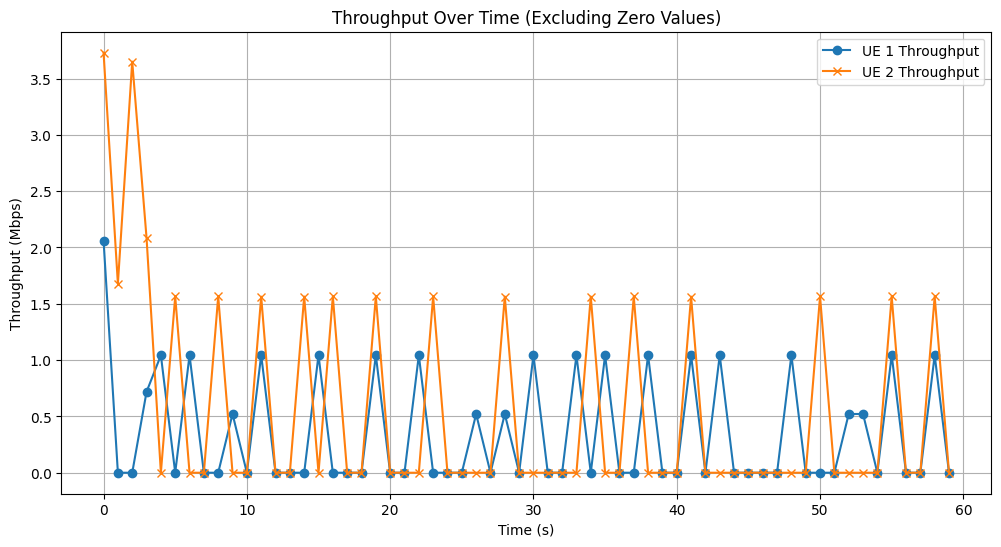

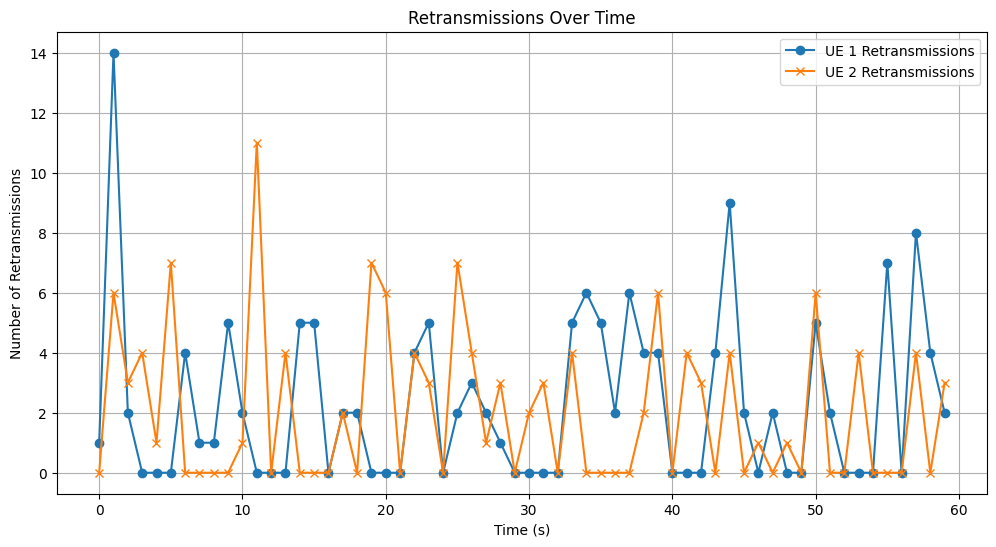

In [90]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with the paths to your actual iperf JSON result files
file1 = 'cubic_ecn_none-result-ue1.json'
file2 = 'cubic_ecn_none-result-ue2.json'

def load_iperf_data(filename):
    """Load iperf JSON data from a file and return a pandas DataFrame."""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Initialize lists to store the extracted data
    intervals = data['intervals']
    start_times = []
    end_times = []
    durations = []
    throughputs = []
    retransmissions = []
    
    # Iterate over each interval in the data
    for interval in intervals:
        sum_data = interval['sum']
        start_times.append(sum_data['start'])
        end_times.append(sum_data['end'])
        durations.append(sum_data['seconds'])
        # Convert throughput from bits per second to megabits per second
        throughput_mbps = sum_data['bits_per_second'] / 1_000_000  # Divide by 1,000,000
        throughputs.append(throughput_mbps)
        retransmissions.append(sum_data.get('retransmits', 0))  # Retransmits might not be present in UDP tests
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Start Time': start_times,
        'End Time': end_times,
        'Duration': durations,
        'Throughput (Mbps)': throughputs,
        'Retransmissions': retransmissions
    })
    
    return df

def filter_zero_throughput(df):
    """Filter out data points where throughput is zero."""
    return df[df['Throughput (Mbps)'] != 0].reset_index(drop=True)

# Load data from both files
df1 = load_iperf_data(file1)
df2 = load_iperf_data(file2)

# Filter out zero throughput data points for plotting throughput
# df1_nonzero = filter_zero_throughput(df1)
# df2_nonzero = filter_zero_throughput(df2)

# Calculate overall throughput and average retransmissions for each dataset
overall_throughput1 = df1['Throughput (Mbps)'].mean()
average_retransmits1 = df1['Retransmissions'].mean()

overall_throughput2 = df2['Throughput (Mbps)'].mean()
average_retransmits2 = df2['Retransmissions'].mean()

print(f"Dataset 1 - Overall Throughput: {overall_throughput1:.2f} Mbps")
print(f"Dataset 1 - Average Retransmissions: {average_retransmits1:.2f}")

print(f"\nDataset 2 - Overall Throughput: {overall_throughput2:.2f} Mbps")
print(f"Dataset 2 - Average Retransmissions: {average_retransmits2:.2f}")

# Plotting the throughputs over time (excluding zero throughput data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Throughput (Mbps)'], label='UE 1 Throughput', marker='o')
plt.plot(df2['Start Time'], df2['Throughput (Mbps)'], label='UE 2 Throughput', marker='x')
plt.title('Throughput Over Time (Excluding Zero Values)')
plt.xlabel('Time (s)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the retransmissions over time (include all data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Retransmissions'], label='UE 1 Retransmissions', marker='o')
plt.plot(df2['Start Time'], df2['Retransmissions'], label='UE 2 Retransmissions', marker='x')
plt.title('Retransmissions Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Retransmissions')
plt.legend()
plt.grid(True)
plt.show()


COMMENT: the cwnd calculation is not showing the expected result. 

In [91]:

name_tx0="cubic_ecn_none"


# the csv files generated is of the following format
# timestamp, fd, cwnd, srtt

file_out_tx0_csv = name_tx0+"-ss.csv"

for ue_id in range(1, 3):
    print("Running to generate csv files " + name_tx0)

    ss_tx0_script_processing="""

    f_1={types}; 
    ue_id={ue_id};
    rm -f ${{f_1}}-ss-${{ue_id}}.csv;
    cat ${{f_1}}-ss-${{ue_id}}.txt | sed -e ":a; /<->$/ {{ N; s/<->\\n//; ba; }}"  | grep "iperf3" | grep -v "SYN-SENT"> ${{f_1}}-ss-processed-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | awk '{{print $1}}' > ts-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bcwnd:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' ' > cwnd-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\brtt:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' '  | cut -d '/' -f 1   > srtt-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bfd=.*?(\s|$)' | awk -F '[=,]' '{{print $2}}' | tr -d ')' | tr -d ' '   > fd-${{f_1}}-${{ue_id}}.txt;
    paste ts-${{f_1}}-${{ue_id}}.txt fd-${{f_1}}-${{ue_id}}.txt cwnd-${{f_1}}-${{ue_id}}.txt srtt-${{f_1}}-${{ue_id}}.txt -d ',' > ${{f_1}}-ss-${{ue_id}}.csv;""".format(types=name_tx0, ue_id="ue"+str(ue_id))

    tx.run(ss_tx0_script_processing)

tx.get("cubic_ecn_none"+"-ss-ue1.csv")
tx.get("cubic_ecn_none"+"-ss-ue2.csv")


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_34072\2911777773.py:12: SyntaxWarning: invalid escape sequence '\s'
  ss_tx0_script_processing="""


Running to generate csv files cubic_ecn_none
Running to generate csv files cubic_ecn_none


In [92]:
import itertools
import json
import pandas as pd

throughput_data = {}  # Initialize the dictionary
srtt_data = {}
cwnd_data= pd.DataFrame()
srtt_data_time= pd.DataFrame()

for ue_id in range(1, 3):
    name_tx0="cubic_ecn_none"
    ue_str = "ue"+str(ue_id)

    # Load the JSON output file into a Python object
    with open(f"{name_tx0}-result-{ue_str}.json") as f:
        iperf3_data = json.load(f)

    throughput_data[name_tx0+ue_str] = iperf3_data['end']['sum_received']['bits_per_second'] / (1000000 * 1)  # to convert Mbit

    # Average SRTT for Each Flow
    columns = ['timestamp', 'flow ID', 'cwnd', 'srtt']
    df_f1 = pd.read_csv(f"{name_tx0}-ss-{ue_str}.csv", names=columns)
    
    # Filter out rows with flow ID = 4, they are for the control flows
    df_f1 = df_f1[df_f1['flow ID'] != 4].reset_index(drop=True)

    average_RTT_f1 = df_f1['srtt'].mean()
    
    cwnd_data[name_tx0+ue_str] = df_f1['cwnd']
    srtt_data[name_tx0+ue_str] = average_RTT_f1
    srtt_data_time[name_tx0+ue_str] = df_f1['srtt']

# Save throughput_data to a JSON file
with open('throughput_data.json', 'w') as f:
    json.dump(throughput_data, f)

# Save srtt_data to a JSON file
with open('srtt_data.json', 'w') as f:
    json.dump(srtt_data, f)

cwnd_data.to_csv("consolidated_cwnd_data.csv", index=False)
srtt_data_time.to_csv("time_srtt.csv", index=False)

btl limit no ecn:  625000


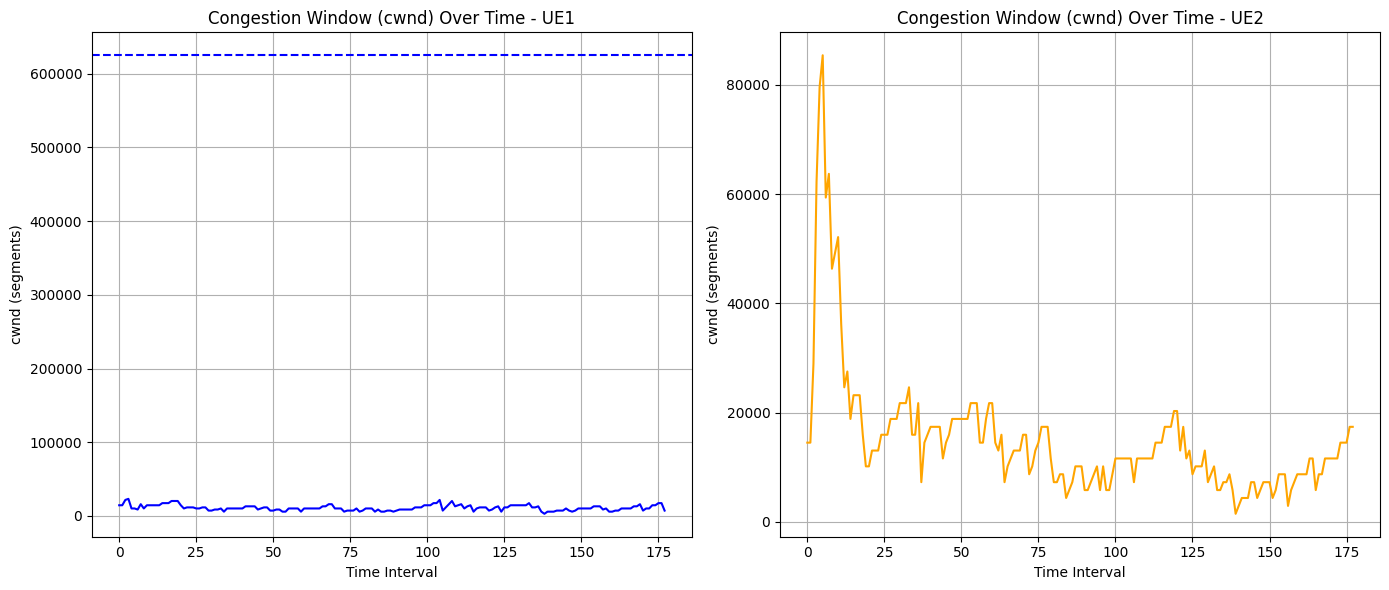

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

btl_limit_noecn=int(1000*btl_capacity*base_rtt*n_bdp /8)

print("btl limit no ecn: ", btl_limit_noecn)

# Specify the filename
filename = 'consolidated_cwnd_data.csv'  # Replace with your actual filename

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename)

# Extract data for each UE
ue1_data = df['cubic_ecn_noneue1']
ue2_data = df['cubic_ecn_noneue2']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for UE1
axes[0].plot(ue1_data*1448, marker='', color='blue')
axes[0].set_title('Congestion Window (cwnd) Over Time - UE1')
axes[0].set_xlabel('Time Interval')
axes[0].set_ylabel('cwnd (segments)')
axes[0].axhline(y=btl_limit_noecn, color='b', linestyle='--', label=f'Buffer Size')
axes[0].grid(True)

# Plot for UE2
axes[1].plot(ue2_data*1448, marker='', color='orange')
axes[1].set_title('Congestion Window (cwnd) Over Time - UE2')
axes[1].set_xlabel('Time Interval')
axes[1].set_ylabel('cwnd (segments)')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [94]:
router.get("monitor.log")

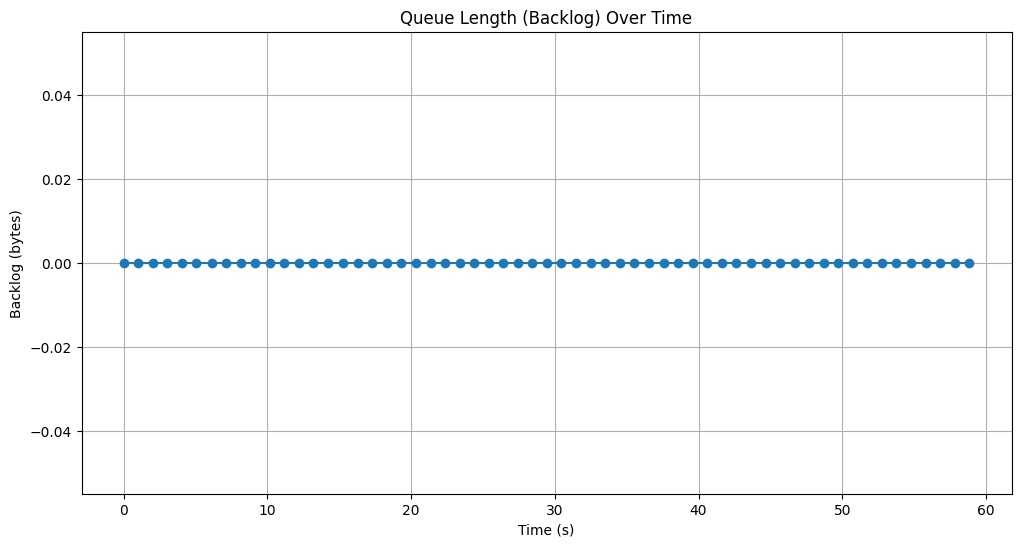

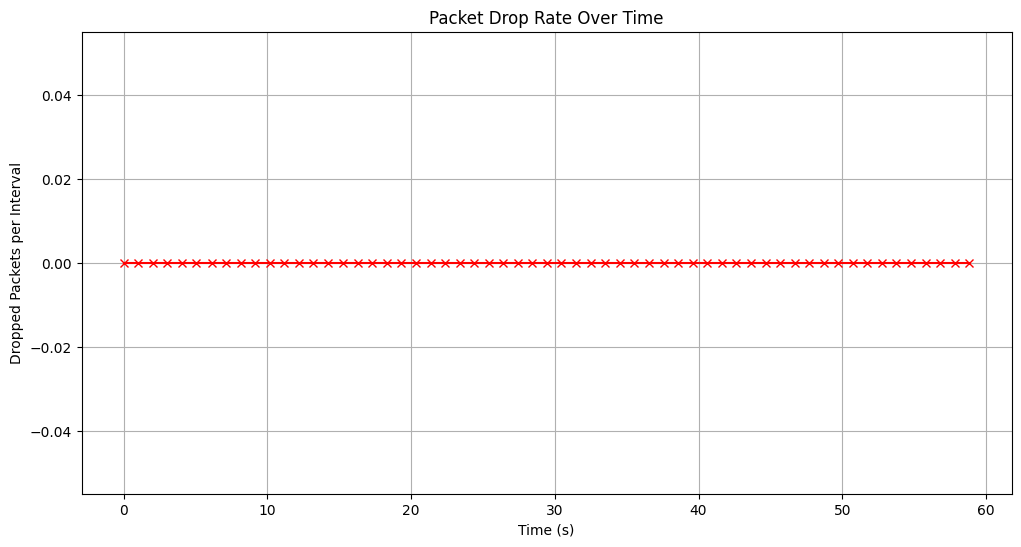

There is no backlog. The queue is empty throughout the measurements.


In [95]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual filename
filename = 'monitor.log'

def parse_qdisc_data(filename):
    """Parse qdisc data from a file and return a DataFrame."""
    timestamps = []
    sent_bytes = []
    sent_packets = []
    dropped_packets = []
    overlimits = []
    backlog_bytes = []
    backlog_packets = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            # Extract timestamp
            match_time = re.match(r'^(\d+\.\d+)', line)
            if match_time:
                timestamp = float(match_time.group(1))
                timestamps.append(timestamp)
            else:
                continue  # Skip line if timestamp not found

            # Extract bfifo qdisc statistics
            # Assuming 'qdisc bfifo' appears after 'qdisc htb' in the line
            bfifo_data = line.split('qdisc bfifo')[1]

            # Extract Sent bytes and packets
            match_sent = re.search(r'Sent\s+(\d+)\s+bytes\s+(\d+)\s+pkt', bfifo_data)
            if match_sent:
                sent_bytes.append(int(match_sent.group(1)))
                sent_packets.append(int(match_sent.group(2)))
            else:
                sent_bytes.append(None)
                sent_packets.append(None)

            # Extract dropped packets
            match_dropped = re.search(r'dropped\s+(\d+)', bfifo_data)
            if match_dropped:
                dropped_packets.append(int(match_dropped.group(1)))
            else:
                dropped_packets.append(None)

            # Extract overlimits
            match_overlimits = re.search(r'overlimits\s+(\d+)', bfifo_data)
            if match_overlimits:
                overlimits.append(int(match_overlimits.group(1)))
            else:
                overlimits.append(None)

            # Extract backlog bytes and packets
            match_backlog = re.search(r'backlog\s+(\d+)b\s+(\d+)p', bfifo_data)
            if match_backlog:
                backlog_bytes.append(int(match_backlog.group(1)))
                backlog_packets.append(int(match_backlog.group(2)))
            else:
                backlog_bytes.append(None)
                backlog_packets.append(None)

    # Create a DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Sent Bytes': sent_bytes,
        'Sent Packets': sent_packets,
        'Dropped Packets': dropped_packets,
        'Overlimits': overlimits,
        'Backlog Bytes': backlog_bytes,
        'Backlog Packets': backlog_packets
    })

    # Convert timestamps to relative time (seconds since start)
    df['Relative Time'] = df['Timestamp'] - df['Timestamp'].iloc[0]

    return df

def plot_queue_length(df):
    """Plot queue length (backlog) over time."""
    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Backlog Bytes'], marker='o')
    plt.title('Queue Length (Backlog) Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Backlog (bytes)')
    plt.grid(True)
    plt.show()

def plot_packet_drop_rate(df):
    """Plot packet drop rate over time."""
    # Calculate the difference in dropped packets between measurements
    df['Dropped Packets Diff'] = df['Dropped Packets'].diff().fillna(0)

    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Dropped Packets Diff'], marker='x', color='red')
    plt.title('Packet Drop Rate Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Dropped Packets per Interval')
    plt.grid(True)
    plt.show()

def analyze_backlog(df):
    """Analyze backlog and determine if there is a backlog."""
    max_backlog = df['Backlog Bytes'].max()
    if max_backlog > 0:
        print(f"There is a backlog. Maximum backlog is {max_backlog} bytes.")
    else:
        print("There is no backlog. The queue is empty throughout the measurements.")

# Main execution
df = parse_qdisc_data(filename)

# Plot queue length
plot_queue_length(df)

# Plot packet drop rate
plot_packet_drop_rate(df)

# Analyze backlog
analyze_backlog(df)
